# Problem set 3. Transitions for Hugget: Debt and Pareto Improvements

Author: Yuxuan Zhao

Date: 2026-02-22

Modified from the code provided by Professor Manuel Amador.

In [38]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rc("savefig", dpi=120)
import numba as nb
import time

In [39]:
beta= 0.95
rho = 2
phi = 0
n = 2 # number of endowment shocks
p = np.array([[.5, .5], 
              [0.2, 0.8]])  # transition probability for the endowment shocks
y_grid = np.array([0.5, 1.0]) # endowment shocks


grid_points = 10000 # for the asset holdings 
a_max = 5  # this is just a guess
a_min = 0
a_grid = np.linspace(a_min, a_max, grid_points) # grid for ahat

In [40]:
@nb.jit
def u(c):
    return c ** (1 - rho) / (1 - rho) 

@nb.jit
def solve_household(R, tolerance=10**(-4)):
    v_0 = np.zeros((grid_points, n))
    v_1 = np.empty((grid_points, n))
    pol_1 = np.empty((grid_points, n), dtype=np.int32)
    beta_v_exp = np.empty((grid_points, n))
    iter = 0
    while True:
        distance = 0.0
        iter += 1
        for s in range(n):  # pre-computing the expected value term
            for i in range(grid_points):
                accum = 0.0
                for sprime in range(n):
                    accum = accum + beta * p[s, sprime] * v_0[i, sprime]
                beta_v_exp[i, s] = accum
        for s in range(n):  # doing the optimization
            pol = 0
            for i in range(grid_points):
                just_started = True
                j = pol # policy is monotonic -- start from the previous optimal policy
                while j < grid_points:
                    c = R * a_grid[i] + y_grid[s] - a_grid[j]
                    if c > 0.0:
                        temp = u(c) + beta_v_exp[j, s] 
                        if just_started:
                            vmax = temp
                            pol = j
                            just_started = False
                        elif temp > vmax:
                            vmax = temp
                            pol = j
                        else:
                            # value decreased -- concavity means it can't go up again
                            break
                    j += 1
                v_1[i, s] = vmax
                pol_1[i, s] = pol
                dis = abs(vmax - v_0[i, s])
                if dis > distance: 
                    distance = dis
        if distance < tolerance:
            break
        else:
            temp2 = v_0
            v_0 = v_1
            v_1 = temp2
    return v_1, pol_1


@nb.jit
def get_stationary_distribution(policy, tolerance=10**(-7)):
    pdf_0 = np.ones((grid_points, n)) / (grid_points * n)
    while True:
        pdf_1 = np.zeros((grid_points, n))
        for i in range(grid_points):
            for s in range(n):
                for sprime in range(n):
                    pdf_1[policy[i, s], sprime] += p[s, sprime] * pdf_0[i, s]
        distance = 0.0
        for i in range(grid_points):
            for s in range(n):
                distance = max(abs(pdf_1[i, s] - pdf_0[i, s]), distance)
        if distance - tolerance < 0:
            break
        else:
            pdf_0 = pdf_1
    return pdf_1


def do_pdf_plots(pdf_ss):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    pdf_assets = np.zeros((grid_points)) 
    for i in range(grid_points):
            pdf_assets[i] = np.sum(pdf_ss[i, :])
    plt.plot(a_grid, pdf_assets)
    plt.xlabel('$\hat{a}$', fontsize=16)
    plt.title('Stationary PDF over assets');

    plt.subplot(122)
    plt.plot(a_grid, np.cumsum(pdf_assets), lw = 1)
    plt.xlabel('$\hat{a}$', fontsize=16)
    plt.title('Stationary CDF over assets')






<>:82: SyntaxWarning: invalid escape sequence '\h'
<>:87: SyntaxWarning: invalid escape sequence '\h'
<>:82: SyntaxWarning: invalid escape sequence '\h'
<>:87: SyntaxWarning: invalid escape sequence '\h'
C:\Users\30945\AppData\Local\Temp\ipykernel_16624\2031324624.py:82: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel('$\hat{a}$', fontsize=16)
C:\Users\30945\AppData\Local\Temp\ipykernel_16624\2031324624.py:87: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel('$\hat{a}$', fontsize=16)


## Part (a): Maximum interest rate $\bar R$


With CRRA utility, $$u(c)=\frac{c^{1-\rho}}{1-\rho}\quad\Rightarrow\quad u'(c)=c^{-\rho}.$$

From FOC, the Euler condition is for all $s$:
$$
u'(c_s)=\beta R\sum_{s'} p_{ss'}\,u'(c_{s'})+\mu \\

c_s = y(s)+Ra-a' \\

\mu\ge 0,\quad a'\ge 0,\quad \mu(a')=0.
$$

When the borrowing constraint binds at $a=0$, the Euler condition becomes an inequality:
$$u'(c_s)\ge \beta R\sum_{s'} p_{ss'}\,u'(c_{s'}).$$

At $a=0$ we know that consumption equals income in each state: 
$$
c_s=y_s\quad \forall s
$$  

Substitute $c_s=y_s$ into the Euler inequality:
$$u'(y_s)\ge \beta R\sum_{s'} p_{ss'}\,u'(y_{s'})\quad \forall s.$$

Rearranging,
$$
R\le \frac{1}{\beta}\frac{u'(y_s)}{\sum_{s'} p_{ss'}u'(y_{s'})}\quad \forall s.
$$

Hence the maximal interest factor that supports $a=0$ as optimal in every state is
$$
\bar R
=\frac{1}{\beta}\min_{s}\frac{u'(y_s)}{\sum_{s'} p_{ss'}u'(y_{s'})}
=\frac{1}{\beta}\min_{s}\frac{y_s^{-\rho}}{\sum_{s'} p_{ss'}\,y_{s'}^{-\rho}}.
$$


In [41]:
@nb.jit
def u_prime(c):
    return c ** (-rho)

def find_R_bar():
    # Rbar = (1/beta) * min_s  u'(y_s) / E[u'(y_{s'})|s]
    vals = np.empty(n)
    for s in range(n):
        denom = 0.0
        for sprime in range(n):
            denom += p[s, sprime] * u_prime(y_grid[sprime])
        vals[s] = u_prime(y_grid[s]) / denom
    return (1.0 / beta) * np.min(vals)

In [42]:
Rbar = find_R_bar()
print(f"Rbar is {Rbar:.4f}")

Rbar is 0.6579


### Part (b)

From the figure below, we can see that the stationary distribution of assets under $R=\bar R$ puts all mass at $\hat a=0$, while the stationary distribution under $R=1$ has positive mass on positive assets.

This makes sense. At $\bar R$, we know that:
$$
\bar R = \frac{1}{\beta}\min_{s}\frac{u'(y_s)}{\sum_{s'} p_{ss'}u'(y_{s'})} \le \frac{1}{\beta}\frac{u'(y_s)}{\sum_{s'} p_{ss'}u'(y_{s'})}\quad \forall s
$$

Thus we know that the Euler equation satisfies:
$$
u'(y_s) \geq \beta \bar R\sum_{s'} p_{ss'}\,u'(y_{s'})\quad \forall s,
$$
We know that $y_0 < y_1$.

We further know that for $s=s_1$, the Euler equation holds with equality, in this state $a=0,s=s_1$, agent is indifferent between saving and not saving, so the optimal policy is $a'(0,s_1)=0$ 
(**Later I will show that the agent is actually strictly better off choosing $a'=0$ than any positive $a'$**).

for $s=s_0$, at $a=0$ the Euler equation holds with inequality, by the slackness condition, we know that the borrowing constraint binds at $a=0$ for that state, so the optimal policy is $a'(0,s)=0$.

Since agents are not allowed to borrow ($a\ge 0$), they also cannot choose negative assets. Hence the optimal policy is $a'(a,s)=0$ for all $(a,s)$, so the stationary distribution puts (essentially) all mass at $\hat a=0$ and aggregate assets satisfy
$$
A=\int a\,d\lambda = 0.
$$

Aggregate savings under Rbar=0.6578947368421052: 0.0000


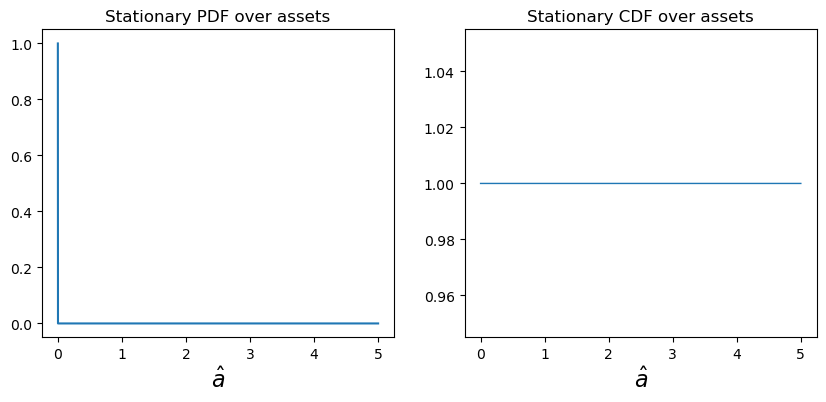

In [43]:
valueA, policyA = solve_household(Rbar)
pdf_ssA = get_stationary_distribution(policyA)

do_pdf_plots(pdf_ssA)

# Calculate the aggregate savings in the stationary distribution under Rbar
agg_savings_A = np.sum(a_grid * np.sum(pdf_ssA, axis=1))
print(f"Aggregate savings under Rbar={Rbar}: {agg_savings_A:.4f}")



Here I will show that at $a=0, s=s_1$, the agent is actually strictly better off choosing $a'=0$ than any positive $a'$.

- First step, we compute the $s \in \{s_0, s_1\}$ for which the Euler equation holds with equality.
- Second step, we compute the Bellman RHS $v(a', a=0, s)$ for all $a'$.
- Third step, we plot the Bellman RHS $v(a', a=0, s)$ over a small range of $a'$ and check if the agent is strictly better off choosing $a'=0$ than any positive $a'$.

The results show that at $s=s_1$, the agent is strictly better off choosing $a'=0$ than any positive $a'$. 

**Previously I thought the agent would be indifferent between $a'=0$ and some positive $a'$, but after plotting the Bellman RHS, I found that the agent is actually strictly better off choosing $a'=0$ than any positive $a'$.**

m_s: [1.6   0.625]
binding state(s) s* (attain min): [1]
s=0: u'(y_s)=4, beta*Rbar*E[u'(y')|s]=1.5625, gap=2.4375
s=1: u'(y_s)=1, beta*Rbar*E[u'(y')|s]=1, gap=1.11022e-16

--- s* = 1 ---
policyA at (a=0,s*): index = 0 , a' = 0.0
argmax over v_rhs:   index = 0 , a' = 0.0
v_rhs(a'=0) = -25.312929459663234 , v_rhs(best) = -25.312929459663234 , diff(best-0) = 0.0


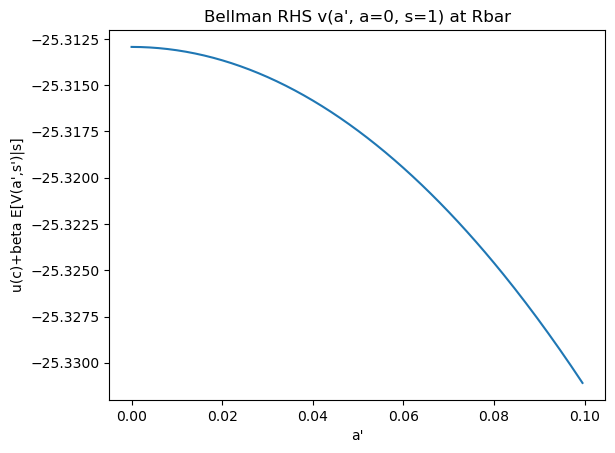

In [44]:
# --- Find the binding state(s) s* for Rbar and check v(a', a=0, s*) as a function of a' ---

# 1) compute m_s = u'(y_s) / E[u'(y_{s'}) | s]
m = np.zeros(n)
for s in range(n):
    denom = 0.0
    for sp in range(n):
        denom += p[s, sp] * u_prime(y_grid[sp])
    m[s] = u_prime(y_grid[s]) / denom

s_star_set = np.where(np.isclose(m, m.min(), rtol=0, atol=1e-14))[0]
print("m_s:", m)
print("binding state(s) s* (attain min):", s_star_set)

# sanity: check Euler equality/inequality at a=0 for each s
for s in range(n):
    lhs = u_prime(y_grid[s])
    rhs = beta * Rbar * sum(p[s, sp] * u_prime(y_grid[sp]) for sp in range(n))
    print(f"s={s}: u'(y_s)={lhs:.6g}, beta*Rbar*E[u'(y')|s]={rhs:.6g}, gap={lhs-rhs:.6g}")

# 2) for each binding state s*, evaluate Bellman RHS at (a=0,s*) over all a' grid points
i0 = 0                 # index for a=0 since a_grid starts at 0
a0 = a_grid[i0]

for s_star in s_star_set:
    v_rhs = np.full(grid_points, -np.inf)  # initialize with -inf for infeasible choices

    # consumption implied by choosing next asset a' at current (a=0,s*)
    c = y_grid[s_star] + Rbar * a0 - a_grid  # here a0=0 so c = y_s* - a'

    feasible = c > 0  # same feasibility logic as in solve_household (no negative consumption)

    # continuation value term: beta * E[V(a',s') | s*]
    EV = np.zeros(grid_points)
    for sp in range(n):
        EV += p[s_star, sp] * valueA[:, sp]   # valueA corresponds to R=Rbar

    v_rhs[feasible] = u(c[feasible]) + beta * EV[feasible]

    # report best discrete choice and compare with policy from solve_household
    j_best = int(np.argmax(v_rhs))
    print("\n--- s* =", s_star, "---")
    print("policyA at (a=0,s*): index =", int(policyA[i0, s_star]),
          ", a' =", a_grid[int(policyA[i0, s_star])])
    print("argmax over v_rhs:   index =", j_best, ", a' =", a_grid[j_best])
    print("v_rhs(a'=0) =", v_rhs[0], ", v_rhs(best) =", v_rhs[j_best],
          ", diff(best-0) =", v_rhs[j_best] - v_rhs[0])

    # plot v_rhs over small a' range to see near-indifference
    K = 200  # show first 200 grid points near 0
    plt.figure()
    plt.plot(a_grid[:K], v_rhs[:K])
    plt.title(f"Bellman RHS v(a', a=0, s={s_star}) at Rbar")
    plt.xlabel("a'")
    plt.ylabel("u(c)+beta E[V(a',s')|s]")
    plt.show()

## Part (c)

We assume the new interest rate is $R'=1$

Since $T_t \equiv 0$, HH's budget constraint remains the same as before. We can write HH probelm as:

$$
V(a,s)=\max_{a'}\left\{u(c)+\beta\sum_{s'}p_{ss'}V(a',s')\right\}, \quad \text{s.t.} \\
a' \geq 0 \\
c = y(s)+R'a+T-a' = y(s)+a-a'
$$

So we can still use the same code we used in part (a) to solve the HH problem and compute the stationary distribution of assets under $R'=1$.

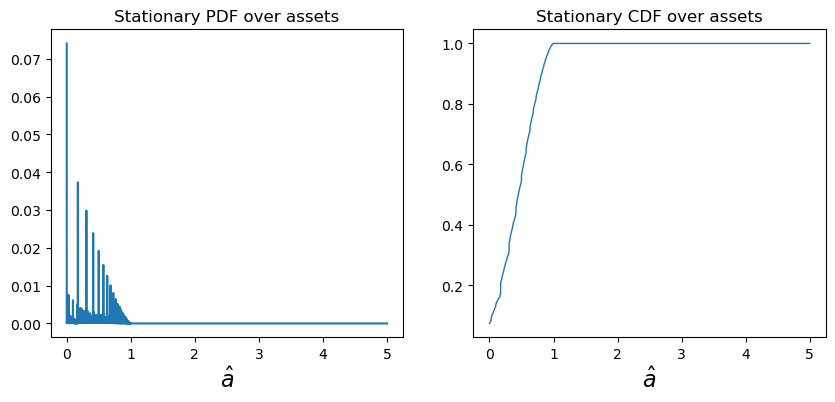

In [45]:
Rprime = 1.0
valueB, policyB = solve_household(Rprime)
pdf_ssB = get_stationary_distribution(policyB)

do_pdf_plots(pdf_ssB)


## Part (d)

We already computed the stationary distribution of assets under $R'=1$ in part (c). The aggregate asset supply in the stationary distribution under $R'=1$ is
$$
A^{ss}(R'=1)=\int a\,d\lambda^{ss}=0.4464.
$$

With no capital and no other assets, the only asset demand in the economy is one-period government debt. Therefore the asset market clearing condition is
$$
A_t = B_t \quad \text{for all } t,
$$
so in a stationary equilibrium with $R'=1$ the government must supply debt equal to households’ desired asset holdings:
$$
B^{ss}=A^{ss}(R'=1)=0.4464.
$$
The government budget constraint is
$$
B_{t+1}-R'B_t \ge T_t,
$$
and since $T_t=0$ and $R'=1$, we know that:
$$
B_{t+1}-B_t \ge 0.
$$
A stationary debt level $B_{t+1}=B_t=B^{ss}$ satisfies the constraint with equality, thus this policy is feasible in the steady state for the government.

In [46]:
# Calculate the aggregate savings in the stationary distribution under Rprime
agg_savings_B = np.sum(a_grid * np.sum(pdf_ssB, axis=1))
print(f"Aggregate savings under R'={Rprime}: {agg_savings_B:.4f}")
print(f"Aggregate government bonds being issued in the steady state: {agg_savings_B:.4f}")


Aggregate savings under R'=1.0: 0.4464
Aggregate government bonds being issued in the steady state: 0.4464


## Part (e)

Start from the household budget constraint
$$
c_t+a_{t+1}=y_t+R'a_t+T_t.
$$
Aggregating across households gives:
$$
C_t+A_{t+1}=Y+R'A_t+T_t.
$$
Using asset market clearing $A_t=B_t$ for all $t$, we obtain
$$
C_t+B_{t+1}=Y+R'B_t+T_t.
$$
Rearrange:
$$
Y - C_t = B_{t+1} - R'B_t - T_t
$$
We need to check if $Y-C_t \ge 0$ in the steady state, which is equivalent to checking if $B_{t+1}-R'B_t \ge T_t$ in the steady state.

In the steady state, we have $B_{t+1}=B_t=B^{ss} = 0.4464$, $T_t=0$ and $R'=1$, so we have
$$
B_{t+1}-R'B_t = 0.4464 - 1 \times 0.4464 = 0
T_t=0 \\
B_{t+1}-R'B_t - T_t = 0
$$
Thus we have
$$
Y - C^{ss} = B_{t+1} - R'B_t - T_t = 0
$$
We have $Y = C^{ss}$, so there isn't any resources lost in the new steady state.

## Part (f)

If $\bar R < R' < 1$, since $\bar R$ is the maximum interest rate that all households choose to save zero assets, we know that at $R' > \bar R$, the optimal policy of the household is to save a positive amount of assets in the stationary distribution, so the stationary distribution has positive mass on $\hat a > 0$ and aggregate asset holdings are positive, by asset market clearing, we have
$$
B^{ss} = A^{ss}(R') = \int a\,d\lambda^{ss} > 0.
$$

- First, we check if this policy is feasible for the government in steady state.

In the steady state $B_{t+1} = B_t = B^{ss}$, $T_t = 0$ for all $t$, then we have
$$
B_{t+1}-R'B_t = B^{ss} - R'B^{ss} = (1-R')B^{ss} > T_t = 0
$$
Thus this policy is feasible for the government in the steady state.

- Then we check if there is any resources lost in the new steady state.

In the new steady state, we have:
$$
Y - C^{ss} = B_{t+1} - R'B_t - T_t = (1-R')B^{ss} > 0
$$
Thus we have $Y > C^{ss}$, so there are resources lost in the new steady state.

## Part (g)


Define the Bellman operater $K$ as:
$$
(K \cdot V)(a,s)=\max_{a'}\left\{u(c)+\beta\sum_{s'}p_{ss'}V(a',s')\right\}, \quad \text{s.t.} \\
c = y(s)+R'a+T-a' = y(s)+a-a' \\
a' \geq 0 
$$


From $t=0$ onward, the policy sets $R_t\equiv R'=1$ and $T_t\equiv 0$.

Suppose at $t = T$ the economy reaches new steady state, HH's problem at $t = T$ can be written as:
$$
V_T = K \cdot V_{T+1}
$$
$V_T(\cdot) = V_{T+1}(\cdot) \equiv V_B(\cdot)$ is the value function at the new steady state, thus we can rewrite HH's problem as:
$$
V_B = K \cdot V_B
$$

At $t = T-1$, HH's problem can be written as:
$$
V_{T-1} = K \cdot V_T = K \cdot V_B = V_B
$$
then we know that $V_{T-1} = V_B$, the HH's problem at $t = T-1$ is same as the HH's problem at $t = T$.

Use backward induction, we can show that HH's problem at any $t \leq T$ is the same as the HH's problem at $t = T$, thus we have $V_t = V_B$ for all $t \leq T$.

Therefore the optimal policy $a'=g(a,s)$ is time-invariant and coincides with the policy solved under $(R',T)=(1,0)$ in part (c).

## Part (h)

Set $T=100$, start from the old steady state, compute the transition path of the economy for 100 periods under the policy $(R',T)=(1,0)$.

We already have the policy function $a_{t+1}=g_t(a_t,s_t) = g(a_t,s_t)$.

Let $\lambda_t$ be the distribution of (a,s) at time $t$. We can calculate $\lambda_{t+1}$ from $\lambda_t$ and the policy function $a'=g(a,s)$ as follows:
$$
\lambda_{t+1}(a',s') = \sum_{s} \int \mathbf{1}\{a' = g(a,s)\} p_{ss'} \lambda_t(a,s) da
$$

In [47]:
# Part (h): forward iteration for T=100 using policy from part (c)

T = 100  # transition length

@nb.njit
def forward_transition_pdfs(policy, pdf_init, T):
    """
    policy: (grid_points, n) integer indices for a' grid choice
    pdf_init: (grid_points, n) initial joint distribution at t=0
    returns: pdf_path with shape (T+1, grid_points, n), including t=0,...,T
    """
    pdf_path = np.zeros((T + 1, grid_points, n))
    pdf_path[0, :, :] = pdf_init

    for t in range(T):
        pdf_new = np.zeros((grid_points, n))
        pdf_old = pdf_path[t, :, :]

        for i in range(grid_points):
            for s in range(n):
                    for sp in range(n):
                        pdf_new[policy[i, s], sp] += p[s, sp] * pdf_old[i, s]

        pdf_path[t + 1, :, :] = pdf_new

    return pdf_path



After computing the transition path of the distribution $\lambda_t$ for $t=0,1,\ldots,T$, I am curious about how the cross-sectional asset distribution evolves over time and how asset inequality changes along the transition.

I report two figures:

1. **Gini coefficient over time.**  
For each date $t$, let $\mu_t=\int a\, d\lambda_t(a)$ be mean assets.  
The Gini coefficient can be written as
$$
G_t=\frac{1}{2\mu_t}\int\!\!\int |a-a'|\, d\lambda_t(a)\, d\lambda_t(a').
$$
In the code, I compute it using the equivalent Lorenz-curve formula:
$$
G_t = 1 - 2\int_0^1 L_t(p)\,dp,
$$
where $L_t(p)$ is the Lorenz curve of assets at date $t$.

2. **Asset CDFs at selected dates.**  
I also plot the dynamics of CDF of assets, at several dates in the transition to visualize how mass shifts across the asset grid.


Mass at t=0,1,2,100: 0.9999999999999989 0.9999999999999989 0.9999999999999989 1.000000000000003
Max mass error: 3.1086244689504383e-15


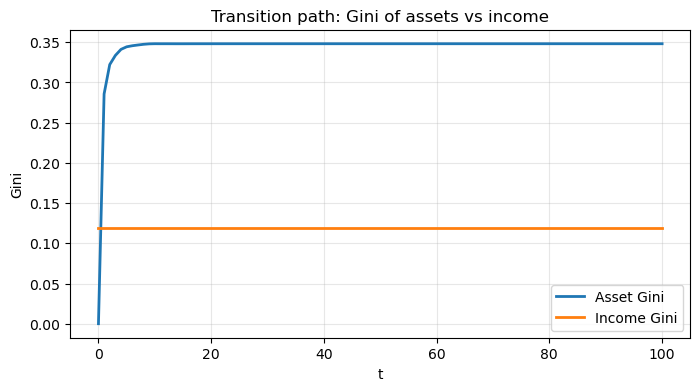

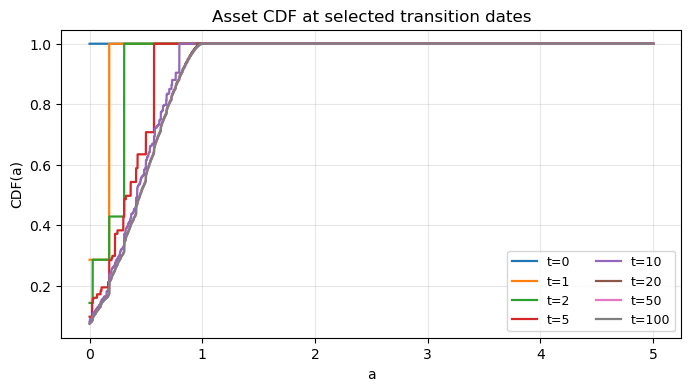

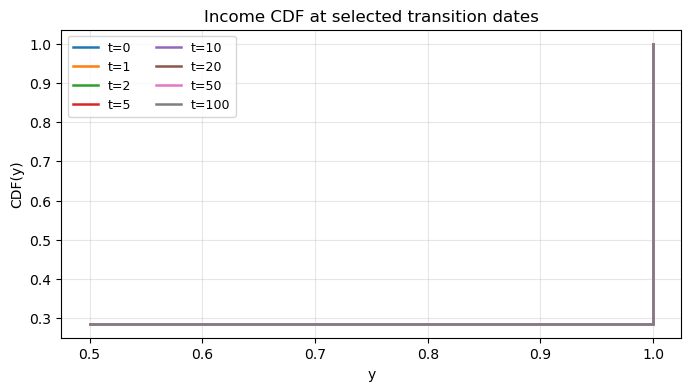

In [48]:

# initial distribution from part (b), policy from part (c)
pdf_transition = forward_transition_pdfs(policyB, pdf_ssA, T)

# quick checks
mass_by_t = np.sum(pdf_transition, axis=(1, 2))
print("Mass at t=0,1,2,100:", mass_by_t[0], mass_by_t[1], mass_by_t[2], mass_by_t[T])
print("Max mass error:", np.max(np.abs(mass_by_t - 1.0)))

# plot Gini path (assets) from t=0 to t=T
def gini_from_asset_pdf(a_vals, w_vals):
    """
    Compute the Gini coefficient for the asset distribution.
    a_vals: asset grid (sorted in ascending order)
    w_vals: probability mass on each asset grid point (sums to 1)
    """
    w = w_vals / np.sum(w_vals)
    mu = np.sum(w * a_vals)

    # If mean assets are (numerically) zero, set Gini to zero.
    if mu <= 1e-14:
        return 0.0

    # Build Lorenz curve components:
    # cw = cumulative population share
    # cy = cumulative asset share
    cw = np.cumsum(w)
    cy = np.cumsum(w * a_vals) / mu

    # Add origin (0,0) for trapezoid integration.
    cw0 = np.concatenate(([0.0], cw))
    cy0 = np.concatenate(([0.0], cy))

    # Area under the Lorenz curve via trapezoid rule.
    B = np.sum(0.5 * (cy0[1:] + cy0[:-1]) * (cw0[1:] - cw0[:-1]))

    # Gini = 1 - 2 * (area under Lorenz curve).
    return 1.0 - 2.0 * B

# plot Gini path (income) from t=0 to t=T

def gini_from_income_pdf(y_vals, w_vals):
    """
    Compute the Gini coefficient for the income distribution (discrete states).
    y_vals: income values (can be unsorted)
    w_vals: probability mass on each income state (sums to 1)
    """
    y = np.asarray(y_vals, dtype=float)
    w = np.asarray(w_vals, dtype=float)
    w = w / np.sum(w)

    mu = np.sum(w * y)

    # If mean income is (numerically) zero, set Gini to zero.
    if mu <= 1e-14:
        return 0.0

    # Sort by income to build Lorenz curve
    idx = np.argsort(y)
    y_s = y[idx]
    w_s = w[idx]

    cw = np.cumsum(w_s)                 # cumulative population share
    cy = np.cumsum(w_s * y_s) / mu      # cumulative income share

    # Add origin for trapezoid integration.
    cw0 = np.concatenate(([0.0], cw))
    cy0 = np.concatenate(([0.0], cy))

    # Area under Lorenz curve
    B = np.sum(0.5 * (cy0[1:] + cy0[:-1]) * (cw0[1:] - cw0[:-1]))

    return 1.0 - 2.0 * B



# 1) Gini coefficient over the full transition.
gini_path = np.zeros(T + 1)
for t in range(T + 1):
    # Collapse joint PDF over (a, s) into marginal PDF over assets.
    pdf_assets_t = np.sum(pdf_transition[t], axis=1)
    gini_path[t] = gini_from_asset_pdf(a_grid, pdf_assets_t)

gini_income_path = np.zeros(T + 1)
for t in range(T + 1):
    # Collapse joint PDF over (a, s) into marginal PDF over income states.
    pdf_income_t = np.sum(pdf_transition[t], axis=0)   # shape (n,)
    gini_income_path[t] = gini_from_income_pdf(y_grid, pdf_income_t)

# Plot asset Gini and income Gini on the same figure
t_grid = np.arange(T + 1)

plt.figure(figsize=(8, 4))
plt.plot(t_grid, gini_path, lw=2, label="Asset Gini")
plt.plot(t_grid, gini_income_path, lw=2, label="Income Gini")
plt.xlabel("t")
plt.ylabel("Gini")
plt.title("Transition path: Gini of assets vs income")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 2) Plot asset CDFs for selected dates on one figure.
selected_t = [0, 1, 2, 5, 10, 20, 50, T]
selected_t = sorted(set([tt for tt in selected_t if 0 <= tt <= T]))

plt.figure(figsize=(8, 4))
for tt in selected_t:
    pdf_assets_tt = np.sum(pdf_transition[tt], axis=1)
    cdf_assets_tt = np.cumsum(pdf_assets_tt)
    plt.plot(a_grid, cdf_assets_tt, lw=1.6, label=f"t={tt}")

plt.xlabel("a")
plt.ylabel("CDF(a)")
plt.title("Asset CDF at selected transition dates")
plt.legend(ncol=2, fontsize=9)
plt.grid(alpha=0.3)
plt.show()



# 3) Plot income CDFs for selected dates on one figure.
selected_t = [0, 1, 2, 5, 10, 20, 50, T]
selected_t = sorted(set([tt for tt in selected_t if 0 <= tt <= T]))

plt.figure(figsize=(8, 4))
y_sorted_idx = np.argsort(y_grid)
y_sorted = y_grid[y_sorted_idx]

for tt in selected_t:
    pdf_income_tt = np.sum(pdf_transition[tt], axis=0)          # (n,)
    pdf_income_tt = pdf_income_tt[y_sorted_idx]                 # sort by y
    cdf_income_tt = np.cumsum(pdf_income_tt)
    plt.step(y_sorted, cdf_income_tt, where="post", lw=1.8, label=f"t={tt}")

plt.xlabel("y")
plt.ylabel("CDF(y)")
plt.title("Income CDF at selected transition dates")
plt.legend(ncol=2, fontsize=9)
plt.grid(alpha=0.3)
plt.show()


## Part (i)

Using the stored transition distributions $\{\lambda_t\}_{t=0}^T$, I compute household aggregate savings at each date:
$$
A_t=\int a\,d\lambda_t(a,s).
$$

By asset market clearing we know:
$$
B_t = A_t.
$$
So once $A_t$ is computed, the debt path is directly pinned down.

- Then I plot the dynamics of debt $B_t$ over time.

- To report debt relative to output, I compute aggregate endowment
$$
Y=\sum_s \pi(s)\,y(s),
$$
where $\pi$ is the invariant distribution of the income Markov chain, and then plot
$$
\frac{B_t}{Y}, \quad t=0,\dots,T.
$$

- Additionally, I plot the figure:
$$
\frac{B_{t+1} - R'B_{t} - T_t}{Y}, \quad t=0,\dots,T-1.
$$
to see the dynamics of resource waste over time.


Y = 0.857143
B_0 = 0.000000, B_T = 0.446379
Debt-output ratio at t=0: 0.000000
Debt-output ratio at t=T: 0.520776


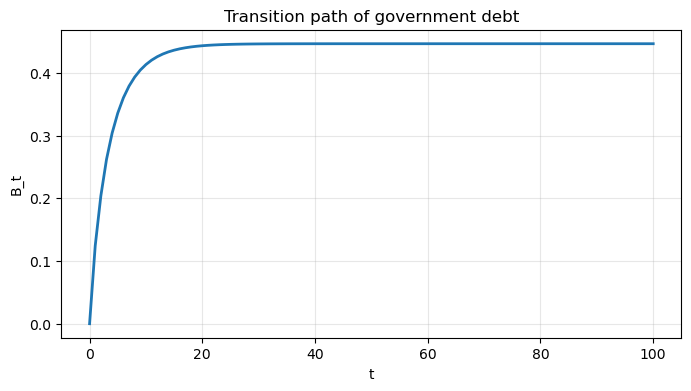

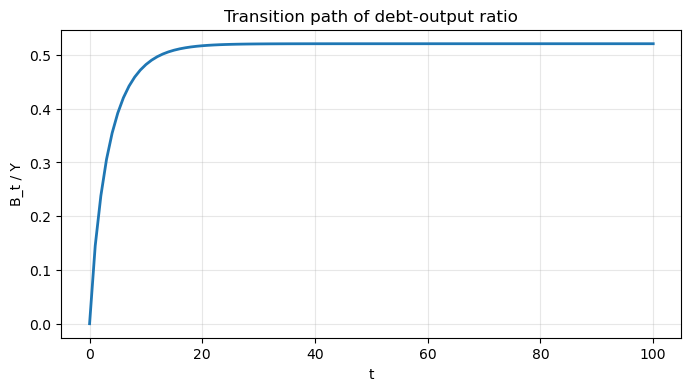

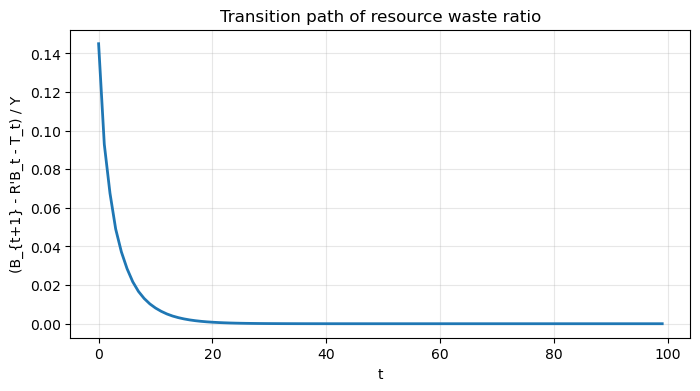

In [49]:
# Part (i)

# 1) Compute aggregate household savings A_t along the transition
A_path = np.zeros(T + 1)
for t in range(T + 1):
    # Marginal distribution over assets at time t
    pdf_assets_t = np.sum(pdf_transition[t], axis=1)
    # A_t = \int a d\lambda_t
    A_path[t] = np.sum(a_grid * pdf_assets_t)

# 2) Asset market clearing: B_t = A_t
B_path = A_path.copy()

# 3) Compute aggregate endowment Y = sum_s pi(s) y(s),
#    where pi is the invariant distribution of the Markov chain p
eigvals, eigvecs = np.linalg.eig(p.T)
idx = np.argmin(np.abs(eigvals - 1.0))
pi_s = np.real(eigvecs[:, idx])
pi_s = pi_s / np.sum(pi_s)   # normalize to sum to 1
pi_s = np.real_if_close(pi_s)

Y = np.sum(pi_s * y_grid)

# 4) Debt-to-output ratio path
BY_path = B_path / Y

# 5) Resource waste ratio:
#    (B_{t+1} - R' B_t - T_t)/Y, with T_t = 0 in this exercise
T_path = np.zeros(T)  # T_t = 0 for t=0,...,T-1
waste_path = (B_path[1:] - Rprime * B_path[:-1] - T_path) / Y

print(f"Y = {Y:.6f}")
print(f"B_0 = {B_path[0]:.6f}, B_T = {B_path[T]:.6f}")
print(f"Debt-output ratio at t=0: {BY_path[0]:.6f}")
print(f"Debt-output ratio at t=T: {BY_path[T]:.6f}")

# ---- Plot 1: debt level B_t ----
plt.figure(figsize=(8, 4))
plt.plot(np.arange(T + 1), B_path, lw=2)
plt.xlabel("t")
plt.ylabel("B_t")
plt.title("Transition path of government debt")
plt.grid(alpha=0.3)
plt.show()

# ---- Plot 2: debt-to-output ratio B_t / Y ----
plt.figure(figsize=(8, 4))
plt.plot(np.arange(T + 1), BY_path, lw=2)
plt.xlabel("t")
plt.ylabel("B_t / Y")
plt.title("Transition path of debt-output ratio")
plt.grid(alpha=0.3)
plt.show()

# ---- Plot 3: resource waste ratio (B_{t+1} - R'B_t - T_t)/Y ----
plt.figure(figsize=(8, 4))
plt.plot(np.arange(T), waste_path, lw=2)
plt.xlabel("t")
plt.ylabel("(B_{t+1} - R'B_t - T_t) / Y")
plt.title("Transition path of resource waste ratio")
plt.grid(alpha=0.3)
plt.show()



From the dynamics of $\frac{B_{t+1} - R'B_t - T_t}{Y}$, we can observe that: Although the new steady state has no resource waste, during the transition there is a period of time where we waste resources, that's the cost of transition. However, as time goes on, the resource waste diminishes and eventually converges to zero in the new steady state. 

## Part (j)

We already computed the dynamics of resources waste:
$$
\frac{B_{t+1} - R'B_t - T_t}{Y} \quad t=0,\dots,T-1.
$$

## Part (k)

For feasibility, the government budget constraint requires
$$
B_{t+1}-R'B_t -T_t \ge 0 \quad \text{for all } t.
$$

From the transition simulation in part (i), we compute the series
$$
\frac{B_{t+1}-R'B_t-T_t}{Y} \quad t=0,\dots,T-1.
$$
is nonnegative at every date. Therefore the policy is feasible.

Hence, the computed transition satisfies the government feasibility condition, HH's optimality condition, asset market clearing condition. Therefore it constitutes an equilibrium transition under the imposed policy $(R_t,T_t)=(1,0)$.


## Part (l)

To compute aggregate consumption along the transition, use the aggregated household budget constraint:
$$
C_t + A_{t+1} = Y + R'A_t + T_t.
$$
Using market clearing $A_t=B_t$ and $T_t=0$, we get
$$
C_t = Y + R'B_t - B_{t+1}, \quad t=0,\dots,T-1.
$$

So I compute $C_t$ from the simulated debt path and plot both $C_t$ and $C_t/Y$.


min(C_t) = 0.732845, max(C_t) = 0.857143
min(C_t/Y) = 0.854986, max(C_t/Y) = 1.000000
max abs((Y-C_t) - (B_{t+1}-R'B_t-T_t)) = 1.6653345369377348e-16


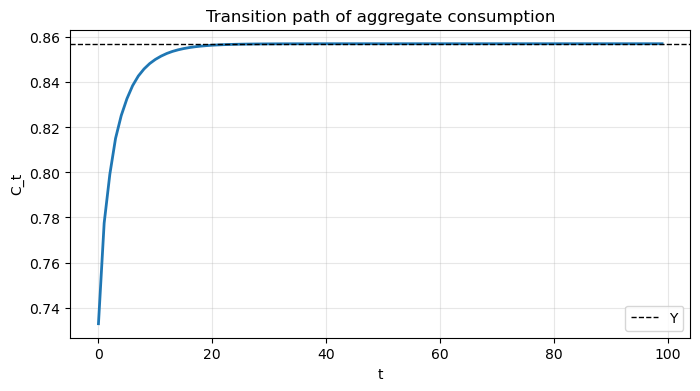

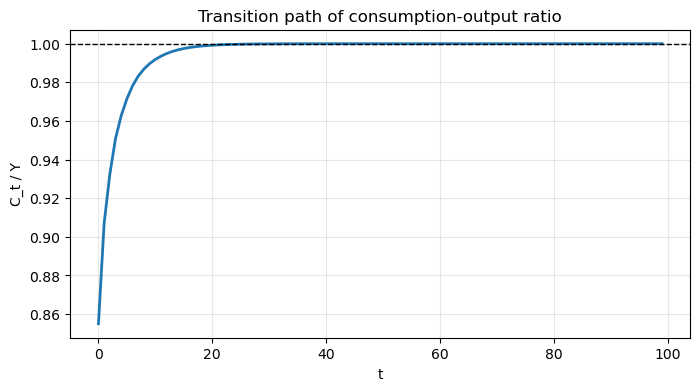

In [50]:
# Part (l): aggregate consumption path

# We need B_t for t=0,...,T and Rprime, Y from part (i).
# Consumption is defined for t=0,...,T-1:
# C_t = Y + R' B_t + T_t - B_{t+1}
T_path = np.zeros(T)   # T_t = 0
C_path = Y + Rprime * B_path[:-1] + T_path - B_path[1:]

# Ratios to output
CY_path = C_path / Y

print(f"min(C_t) = {C_path.min():.6f}, max(C_t) = {C_path.max():.6f}")
print(f"min(C_t/Y) = {CY_path.min():.6f}, max(C_t/Y) = {CY_path.max():.6f}")

# Optional consistency check with part (i):
# Y - C_t should equal B_{t+1} - R'B_t - T_t
lhs = Y - C_path
rhs = B_path[1:] - Rprime * B_path[:-1] - T_path
print("max abs((Y-C_t) - (B_{t+1}-R'B_t-T_t)) =", np.max(np.abs(lhs - rhs)))

# Plot C_t
plt.figure(figsize=(8, 4))
plt.plot(np.arange(T), C_path, lw=2)
plt.axhline(Y, color='k', ls='--', lw=1, label='Y')
plt.xlabel("t")
plt.ylabel("C_t")
plt.title("Transition path of aggregate consumption")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot C_t / Y
plt.figure(figsize=(8, 4))
plt.plot(np.arange(T), CY_path, lw=2)
plt.axhline(1.0, color='k', ls='--', lw=1)
plt.xlabel("t")
plt.ylabel("C_t / Y")
plt.title("Transition path of consumption-output ratio")
plt.grid(alpha=0.3)
plt.show()


## Part (m)

Yes, the new allocation is a Pareto improvement relative to the initial stationary equilibrium.

This policy increases interest rate $R$ and remains feasible for the government. A higher interest rate relaxes each households' budget constraint.

This relaxation is not tied to a particular idiosyncratic income state or utility function; it applies to every household given its asset position. Therefore all households are weakly better off, and at least some are strictly better off, which implies a Pareto improvement.



## Part (n)

We can check this result by comparing the value functions for each household $V^A(a,s)$ and $V^B(a,s)$ and verifying that they are weakly higher under the new policy.

To verify the Pareto-improvement claim numerically, I compare the value functions under the old and new policies **at the initial steady state**:
- $V^A(a,s)$: value under the initial stationary equilibrium (part (b), with $R=\bar R$),
- $V^B(a,s)$: value under the new policy (part (c), with $R'=1$).

Define
$$
\Delta V(a,s)=V^B(a,s)-V^A(a,s).
$$

A Pareto improvement (relative to the initial stationary distribution $\lambda_A$) requires:
1. **Weak improvement for all initially present households**:
$$
\Delta V(a,s)\ge 0 \quad \forall (a,s)\ \text{such that}\ \lambda_A(a,s)>0.
$$
2. **Strict improvement for at least one initially present household**:
$$
\Delta V(a,s)>0 \quad \text{for at least one }(a,s)\ \text{with}\ \lambda_A(a,s)>0.
$$

So in the code, I check $\Delta V$ on the support of $\lambda_A$ (not necessarily on all grid points).  
As an additional stronger diagnostic, I also report whether $\Delta V\ge 0$ on the entire state grid.


In [51]:
# Check Pareto improvement via value functions

tol = 1e-8

# 1) Strong check: everywhere on the state grid
diff_all = valueB - valueA
all_weakly_better_everywhere = np.all(diff_all >= -tol)
any_strictly_better_everywhere = np.any(diff_all > tol)

print("=== Strong check (all grid points) ===")
print("min(VB-VA) over all states:", diff_all.min())
print("all VB >= VA everywhere:", all_weakly_better_everywhere)
print("any VB > VA somewhere:", any_strictly_better_everywhere)

# 2) Pareto-relevant check: only on support of initial stationary distribution lambda_A
support_mask = pdf_ssA > 1e-12
diff_support = diff_all[support_mask]

all_weakly_better_support = np.all(diff_support >= -tol)
any_strictly_better_support = np.any(diff_support > tol)

print("\n=== Pareto-relevant check (support of initial distribution) ===")
print("number of support states:", diff_support.size)
print("min(VB-VA) on support:", diff_support.min())
print("all VB >= VA on support:", all_weakly_better_support)
print("any VB > VA on support:", any_strictly_better_support)

if all_weakly_better_support and any_strictly_better_support:
    print("\nResult: Pareto improvement (relative to initial stationary distribution).")
elif all_weakly_better_support:
    print("\nResult: weak Pareto improvement (no one worse off, no strict gain detected).")
else:
    print("\nResult: not a Pareto improvement (someone in initial support is worse off).")


=== Strong check (all grid points) ===
min(VB-VA) over all states: 0.9664757159426784
all VB >= VA everywhere: True
any VB > VA somewhere: True

=== Pareto-relevant check (support of initial distribution) ===
number of support states: 2
min(VB-VA) on support: 0.9664757159426784
all VB >= VA on support: True
any VB > VA on support: True

Result: Pareto improvement (relative to initial stationary distribution).


## Part (o)

Consider any Huggett economy with no borrowing, $\phi=0$, and initial stationary equilibrium interest rate $R<1$.

Now set policy to
$$
R_t = R' = 1,\qquad T_t=0 \quad \forall t\ge 0,
$$
and start from the initial stationary distribution $\lambda_0$.

Let $\{A_t\}_{t\ge0}$ be the implied sequence of aggregate household savings under this constant-rate policy.

If we have:
$$
A_{t+1}\ge A_t \quad \forall t.
$$

By asset market clearing, we know that
$$
B_t = A_t \\
\Longrightarrow B_{t+1} \ge B_t \quad \forall t.
$$

Government feasibility requires
$$
B_{t+1}-R_tB_t \ge T_t.
$$
With $R_t=1$ and $T_t=0$, this becomes
$$
B_{t+1}-B_t = A_{t+1}-A_t \ge 0,
$$
So the policy is feasible.

Then for household problem, increased interest rate relaxes each households' intertemporal budget constraint. Hence all households in the initial distribution are weakly better off; and if the improvement is strict for some states, this yields a Pareto improvement.


## Part (p)

We introduce a path of policies $\{(R_t,T_t)\}_{t=0}^T$ that transition the economy from the initial stationary equilibrium to the new steady state.

Set the policy as 
$$
R_t=R'=1 \quad \text{and} \quad T_t = B_{t+1}-R_tB_t \quad \text{for all } t\ge T,
$$


- For the new steady state, similar to part (c), we can compute the associated stationary distribution for $R'=1$.


- For the transition path, the household problem is now genuinely time-varying because $T_t$ enters the period budget constraint
$$
c_t + a_{t+1} \le R_t a_t + y_t + T_t.
$$
So we can no longer reuse one stationary policy rule; we must solve a full transition with backward-forward iteration.

### Numerical method of calculating the transition path


1. Choose a finite horizon $T$ and assume that the economy reaches the new steady state at $t=T$ (i.e., $R_t=R'$ and $T_t=0$ for all $t\ge T$).

2. Make an initial guess for a transition path $\{B_t\}_{t=0}^{T}$.

3. Given the guessed path of $\{B_t\}$, we can compute the path of $\{T_t\}$, then we solve households’ dynamic program **backward** from $t=T$ to $t=0$ to obtain the path of value/policy functions $\{V_t,g_t\}$.

    At $t=\tau$, we solve the Bellman equation
    $$
    V_\tau(a,s) = \max_{a'}\left\{u(c)+\beta\sum_{s'}p_{ss'}V_{\tau+1}(a',s')\right\}, \quad \text{s.t.} \\
    c = y(s)+R_\tau a + T_\tau - a' \\
    a' \geq 0
    $$
    Then we get value function $V_\tau(a,s)$ and policy function $a' = g_\tau(a,s)$.


4. Starting from the initial distribution $\lambda_0$, iterate **forward** using $\{g_t\}$ to get $\{\lambda_t\}$

    At $t=\tau$, we have distribution $\lambda_\tau$ and policy function $a' = g_\tau(a,s)$, we can compute the next-period distribution $\lambda_{\tau+1}$:
    $$
    \lambda_{\tau+1}(a',s') = \sum_{s} \int \mathbf{1}\{a' = g_\tau(a,s)\} p_{ss'} \lambda_\tau(a,s) da
    $$


5. We have the path of distributions $\{\lambda_t\}$, we can compute implied aggregates $\{A_t\}$ and impose equilibrium conditions:
    $$
    A_t = \int \int a \lambda_t(a,s) da ds \\
    \hat{B_t} = A_t \quad \text{(asset market clearing)} \\
    \hat{T_t} = \hat{B}_{t+1}-R_t\hat{B}_t \quad \text{(government equality)}.
    $$
    

6. We have updated paths $\{\hat{B_t}\}$, we can update our guess for $\{B_t\}$.
   
    Set 
    $$
    B_t^{new} = \alpha \hat{B_t} + (1-\alpha) B_t^{old}
    $$
    for some $\alpha \in (0,1)$ to ensure convergence. Then go back to step 3 and repeat.

    Stop when the guessed path $\{B_t\}$ converges:
    $$
    \max_t |B_t^{new} - B_t^{old}| < \varepsilon
    $$

7. We now have a transition path $\{\lambda_t\}$, we check whether the economy reaches the new steady state at $t=T$ by comparing the distribution $\lambda_T$ with the stationary distribution under $(R',T)=(1,0)$:
    $$
    \sup_{a,s} | \lambda_T(a,s) - \lambda^{ss}(a,s) | < \varepsilon
    $$
    If not, we can increase $T$ and repeat the procedure until convergence.



In [52]:
# =========================
# Part (p): Full implementation
# Backward-forward iteration with R_t = R' = 1 and T_t = B_{t+1} - R_t B_t
# Includes terminal-distribution check and automatic T extension
# =========================



# ---------- 0) Primitives from your notebook ----------
# Required objects already defined earlier:
# beta, rho, p, y_grid, a_grid, solve_household, get_stationary_distribution
# and (optionally) pdf_ssA from part (b)

Rprime = 1.0

# ---------- 1) Utility ----------
@nb.njit
def u_crra(c, rho):
    if rho == 1.0:
        return np.log(c)
    return c ** (1.0 - rho) / (1.0 - rho)


'''
# ---------- 2) One backward Bellman step ----------
@nb.njit
def bellman_step_given_next(V_next, R_t, T_t, beta, rho, p, y_grid, a_grid):
    grid_points = a_grid.size
    n = y_grid.size

    V_t = np.empty((grid_points, n))
    pol_t = np.empty((grid_points, n), dtype=np.int32)

    # Expected continuation value EV[j,s] = beta * E[V_next(j,s') | s]
    EV = np.empty((grid_points, n))
    for s in range(n):
        for j in range(grid_points):
            acc = 0.0
            for sp in range(n):
                acc += beta * p[s, sp] * V_next[j, sp]
            EV[j, s] = acc

    # Monotone policy search
    for s in range(n):
        pol = 0
        for i in range(grid_points):
            started = False
            vmax = -1e300
            best = pol

            j = pol
            while j < grid_points:
                c = R_t * a_grid[i] + y_grid[s] + T_t - a_grid[j]
                if c > 0.0:
                    val = u_crra(c, rho) + EV[j, s]
                    if (not started) or (val > vmax):
                        vmax = val
                        best = j
                        started = True
                    else:
                        # With concavity, stop once value starts falling
                        # break
                        pass
                j += 1

            if not started:
                # Numerical safeguard
                best = 0
                vmax = -1e300

            V_t[i, s] = vmax
            pol_t[i, s] = best
            pol = best

    return V_t, pol_t
'''

# ---------- 2) One backward Bellman step ----------
@nb.njit
def bellman_step_given_next(V_next, R_t, T_t, beta, rho, p, y_grid, a_grid):
    grid_points = a_grid.size
    n = y_grid.size

    V_t = np.empty((grid_points, n))
    pol_t = np.empty((grid_points, n), dtype=np.int32)

    # Expected continuation value EV[j,s] = beta * E[V_next(j,s') | s]
    EV = np.empty((grid_points, n))
    for s in range(n):
        for j in range(grid_points):
            acc = 0.0
            for sp in range(n):
                acc += beta * p[s, sp] * V_next[j, sp]
            EV[j, s] = acc

    # Robust monotone policy search: fast + less tail chattering
    v_tol = 1e-7
    fall_tol = 1e-6
    confirm_k = 4

    for s in range(n):
        pol = 0
        for i in range(grid_points):
            started = False
            vmax = -1e300
            best = pol
            down_count = 0

            j = pol
            while j < grid_points:
                c = R_t * a_grid[i] + y_grid[s] + T_t - a_grid[j]

                if c <= 0.0:
                    # a_grid is ascending; larger j only makes c smaller
                    break

                val = u_crra(c, rho) + EV[j, s]

                if (not started) or (val > vmax + v_tol):
                    vmax = val
                    best = j
                    started = True
                    down_count = 0
                elif abs(val - vmax) <= v_tol:
                    # flat top: keep current best index
                    down_count = 0
                else:
                    down_count += 1
                    if down_count >= confirm_k and (vmax - val) > fall_tol:
                        break

                j += 1

            if not started:
                best = 0
                vmax = -1e300

            V_t[i, s] = vmax
            pol_t[i, s] = best
            pol = best

    return V_t, pol_t


# ---------- 3) Backward path given {R_t,T_t} ----------
@nb.njit
def backward_paths(R_path, T_path, V_terminal, beta, rho, p, y_grid, a_grid):
    T = R_path.size
    grid_points = a_grid.size
    n = y_grid.size

    V_path = np.empty((T + 1, grid_points, n))
    pol_path = np.empty((T, grid_points, n), dtype=np.int32)

    # Terminal condition at t=T
    V_path[T, :, :] = V_terminal

    # Backward induction
    for t in range(T - 1, -1, -1):
        V_t, pol_t = bellman_step_given_next(
            V_path[t + 1, :, :], R_path[t], T_path[t],
            beta, rho, p, y_grid, a_grid
        )
        V_path[t, :, :] = V_t
        pol_path[t, :, :] = pol_t

    return V_path, pol_path


# ---------- 4) Forward distribution given {g_t} ----------
@nb.njit
def forward_distributions(pol_path, lambda0, p):
    T = pol_path.shape[0]
    grid_points = pol_path.shape[1]
    n = pol_path.shape[2]

    lambda_path = np.zeros((T + 1, grid_points, n))
    lambda_path[0, :, :] = lambda0

    # Forward law of motion for distribution
    for t in range(T):
        nxt = np.zeros((grid_points, n))
        cur = lambda_path[t, :, :]

        for i in range(grid_points):
            for s in range(n):
                mass = cur[i, s]
                if mass > 0.0:
                    ip = pol_path[t, i, s]
                    for sp in range(n):
                        nxt[ip, sp] += p[s, sp] * mass

        lambda_path[t + 1, :, :] = nxt

    return lambda_path

# ---------- 5) Aggregate assets ----------
@nb.njit
def aggregate_assets_path(lambda_path, a_grid):
    T1 = lambda_path.shape[0]
    grid_points = a_grid.size
    n = lambda_path.shape[2]

    A = np.zeros(T1)
    for t in range(T1):
        total = 0.0
        for i in range(grid_points):
            mass_i = 0.0
            for s in range(n):
                mass_i += lambda_path[t, i, s]
            total += a_grid[i] * mass_i
        A[t] = total
    return A

'''
# ---------- 6) Solve transition for fixed T ----------
def solve_transition_with_transfers(
    T=100,
    Rprime=1.0,     # your policy: R' ≡ 1
    max_iter=2000,
    tol=1e-6,
    alpha=0.2,
    verbose=True
):
    # Uses objects from earlier parts: beta, rho, p, y_grid, a_grid, pdf_ssA, pdf_ssB, valueB
    global pdf_ssA, pdf_ssB, valueB

    # Fallbacks if not already in memory
    if "valueB" not in globals():
        valueB, _ = solve_household(Rprime)
    if "pdf_ssA" not in globals():
        _, polA = solve_household(Rbar)
        pdf_ssA = get_stationary_distribution(polA)
    if "pdf_ssB" not in globals():
        _, polB = solve_household(Rprime)
        pdf_ssB = get_stationary_distribution(polB)

    lambda0 = pdf_ssA.copy()
    V_terminal = valueB.copy()  # terminal value at target steady state under (R',T)=(1,0)

    # Initial and target debt levels (from market clearing B=A)
    A0 = np.sum(a_grid * np.sum(lambda0, axis=1))
    B_ss = np.sum(a_grid * np.sum(pdf_ssB, axis=1))

    R_path = np.full(T, Rprime)

    # Initial guess for debt path
    B_guess = np.linspace(A0, B_ss, T + 1)

    err_hist = []
    for it in range(max_iter):
        # Government equality: T_t = B_{t+1} - R_t B_t
        T_guess = B_guess[1:] - R_path * B_guess[:-1]

        # Backward step
        V_path, pol_path = backward_paths(
            R_path, T_guess, V_terminal, beta, rho, p, y_grid, a_grid
        )

        # Forward step
        lambda_path = forward_distributions(pol_path, lambda0, p)

        # Implied aggregate assets A_t
        A_implied = aggregate_assets_path(lambda_path, a_grid)

        # Market clearing update B_t = A_t (with damping)
        B_new = alpha * A_implied + (1.0 - alpha) * B_guess
        B_new[0] = A0  # pin initial condition
        # B_new[-1] = B_ss  # pin terminal condition

        err = np.max(np.abs(B_new - B_guess))
        err_hist.append(err)

        if verbose and ((it + 1) % 10 == 0 or it == 0):
            print(f"iter={it+1:4d}, sup error={err:.3e}")

        B_guess = B_new
        if err < tol:
            if verbose:
                print(f"Converged in {it+1} iterations, error={err:.3e}")
            break
    else:
        print(f"No convergence in {max_iter} iterations. Last error={err_hist[-1]:.3e}")

    # Recompute objects at converged B path
    B_path = B_guess
    T_path = B_path[1:] - R_path * B_path[:-1]
    V_path, pol_path = backward_paths(
        R_path, T_path, V_terminal, beta, rho, p, y_grid, a_grid
    )
    lambda_path = forward_distributions(pol_path, lambda0, p)
    A_path = aggregate_assets_path(lambda_path, a_grid)

    return {
        "B_path": B_path,
        "T_path": T_path,
        "R_path": R_path,
        "A_path": A_path,
        "lambda_path": lambda_path,
        "V_path": V_path,
        "pol_path": pol_path,
        "error_history": np.array(err_hist),
    }


# ---------- 7) Outer loop: increase T until terminal distribution check passes ----------
def solve_transition_auto_T(
    T0=100,
    T_step=50,
    T_max=500,
    dist_tol=1e-4,
):
    """
    Returns:
      res_best, T_used, terminal_error, passed
    """
    T = T0
    res_best = None
    err_best = np.inf
    T_best = None

    while T <= T_max:
        print(f"\nTrying T={T} ...")
        res = solve_transition_with_transfers(T=T)

        final_dist = res["lambda_path"][-1]
        terminal_err = np.max(np.abs(final_dist - pdf_ssB))

        print(f"terminal max abs error = {terminal_err:.3e}")

        if terminal_err < err_best:
            err_best = terminal_err
            res_best = res
            T_best = T

        if terminal_err < dist_tol:
            print(f"Passed terminal check at T={T}.")
            return res, T, terminal_err, True

        T += T_step

    print(f"Did not pass terminal check before T_max={T_max}.")
    print(f"Best was T={T_best}, error={err_best:.3e}.")
    return res_best, T_best, err_best, False
'''



'\n# ---------- 6) Solve transition for fixed T ----------\ndef solve_transition_with_transfers(\n    T=100,\n    Rprime=1.0,     # your policy: R\' ≡ 1\n    max_iter=2000,\n    tol=1e-6,\n    alpha=0.2,\n    verbose=True\n):\n    # Uses objects from earlier parts: beta, rho, p, y_grid, a_grid, pdf_ssA, pdf_ssB, valueB\n    global pdf_ssA, pdf_ssB, valueB\n\n    # Fallbacks if not already in memory\n    if "valueB" not in globals():\n        valueB, _ = solve_household(Rprime)\n    if "pdf_ssA" not in globals():\n        _, polA = solve_household(Rbar)\n        pdf_ssA = get_stationary_distribution(polA)\n    if "pdf_ssB" not in globals():\n        _, polB = solve_household(Rprime)\n        pdf_ssB = get_stationary_distribution(polB)\n\n    lambda0 = pdf_ssA.copy()\n    V_terminal = valueB.copy()  # terminal value at target steady state under (R\',T)=(1,0)\n\n    # Initial and target debt levels (from market clearing B=A)\n    A0 = np.sum(a_grid * np.sum(lambda0, axis=1))\n    B_ss = n

In [55]:
# ---------- 6) Solve transition for fixed T ----------
def solve_transition_with_transfers(
    T=100,
    Rprime=1.0,     # your policy: R' ≡ 1
    max_iter=2000,
    tol=1e-6,
    alpha=0.2,
    tol_tail=5e-5,  # NEW: tail smoothness tolerance
    tail=20,        # NEW: number of tail periods used in criterion
    verbose=True
):
    # Uses objects from earlier parts: beta, rho, p, y_grid, a_grid, pdf_ssA, pdf_ssB, valueB
    global pdf_ssA, pdf_ssB, valueB

    # Fallbacks if not already in memory
    if "valueB" not in globals():
        valueB, _ = solve_household(Rprime)
    if "pdf_ssA" not in globals():
        _, polA = solve_household(Rbar)
        pdf_ssA = get_stationary_distribution(polA)
    if "pdf_ssB" not in globals():
        _, polB = solve_household(Rprime)
        pdf_ssB = get_stationary_distribution(polB)

    lambda0 = pdf_ssA.copy()
    V_terminal = valueB.copy()  # terminal value at target steady state under (R',T)=(1,0)

    # Initial and target debt levels (from market clearing B=A)
    A0 = np.sum(a_grid * np.sum(lambda0, axis=1))
    B_ss = np.sum(a_grid * np.sum(pdf_ssB, axis=1))

    R_path = np.full(T, Rprime)

    # Initial guess for debt path
    B_guess = np.linspace(A0, B_ss, T + 1)

    err_hist = []
    tail_err_hist = []  # NEW
    for it in range(max_iter):
        # Government equality: T_t = B_{t+1} - R_t B_t
        T_guess = B_guess[1:] - R_path * B_guess[:-1]

        # Backward step
        V_path, pol_path = backward_paths(
            R_path, T_guess, V_terminal, beta, rho, p, y_grid, a_grid
        )

        # Forward step
        lambda_path = forward_distributions(pol_path, lambda0, p)

        # Implied aggregate assets A_t
        A_implied = aggregate_assets_path(lambda_path, a_grid)

        # Market clearing update B_t = A_t (with damping)
        B_new = alpha * A_implied + (1.0 - alpha) * B_guess
        B_new[0] = A0  # pin initial condition
        # B_new[-1] = B_ss  # pin terminal condition

        # Criterion 1: fixed-point update size
        err = np.max(np.abs(B_new - B_guess))
        err_hist.append(err)

        # Criterion 2: tail smoothness of path itself
        m = min(tail, T)  # use last m differences among B_t
        if m > 0:
            tail_err = np.max(np.abs(np.diff(B_new[-(m + 1):])))
        else:
            tail_err = 0.0
        tail_err_hist.append(tail_err)

        if verbose and ((it + 1) % 10 == 0 or it == 0):
            print(f"iter={it+1:4d}, sup error={err:.3e}, tail osc={tail_err:.3e}")

        B_guess = B_new
        if (err < tol) and (tail_err < tol_tail):
            if verbose:
                print(
                    f"Converged in {it+1} iterations, "
                    f"error={err:.3e}, tail osc={tail_err:.3e}"
                )
            break
    else:
        print(
            f"No convergence in {max_iter} iterations. "
            f"Last error={err_hist[-1]:.3e}, tail osc={tail_err_hist[-1]:.3e}"
        )

    # Recompute objects at converged B path
    B_path = B_guess
    T_path = B_path[1:] - R_path * B_path[:-1]
    V_path, pol_path = backward_paths(
        R_path, T_path, V_terminal, beta, rho, p, y_grid, a_grid
    )
    lambda_path = forward_distributions(pol_path, lambda0, p)
    A_path = aggregate_assets_path(lambda_path, a_grid)

    return {
        "B_path": B_path,
        "T_path": T_path,
        "R_path": R_path,
        "A_path": A_path,
        "lambda_path": lambda_path,
        "V_path": V_path,
        "pol_path": pol_path,
        "error_history": np.array(err_hist),
        "tail_error_history": np.array(tail_err_hist),  # NEW
    }


In [57]:
# ---------- 6) Solve transition for fixed T ----------
def solve_transition_with_transfers(
    T=100,
    Rprime=1.0,     # your policy: R' ≡ 1
    max_iter=2000,
    tol=1e-6,
    alpha=0.2,
    tol_tail=5e-5,  # tail smoothness tolerance
    tail=20,        # K: number of tail differences regularized
    reg_lambda=50.0,  # λ: smoothness strength
    reg_mu=50.0,      # μ: terminal pull strength
    verbose=True
):
    # Uses objects from earlier parts: beta, rho, p, y_grid, a_grid, pdf_ssA, pdf_ssB, valueB
    global pdf_ssA, pdf_ssB, valueB

    def tail_regularize_projection(B_tilde, K, lam, mu, B_ss):
        """
        Solve on tail block x = B[T-K : T]:
            min ||x - x_tilde||^2
                + lam * sum (x_{i+1} - x_i)^2
                + mu * (x_last - B_ss)^2
        by linear system:
            (I + lam*L + mu*e_T e_T') x = x_tilde + mu*B_ss*e_T
        """
        B_proj = B_tilde.copy()
        m = min(K, B_tilde.size - 1)  # number of tail differences
        if m <= 0 or (lam <= 0.0 and mu <= 0.0):
            return B_proj

        start = B_tilde.size - 1 - m   # tail starts here
        x_tilde = B_tilde[start:].copy()  # length n = m+1
        n = x_tilde.size

        A = np.eye(n)
        b = x_tilde.copy()

        # Add lam * L (1D Laplacian on tail block)
        if lam > 0.0 and n >= 2:
            A[0, 0] += lam
            A[-1, -1] += lam
            for i in range(1, n - 1):
                A[i, i] += 2.0 * lam
            for i in range(n - 1):
                A[i, i + 1] -= lam
                A[i + 1, i] -= lam

        # Add terminal pull mu*(x_last - B_ss)^2
        if mu > 0.0:
            A[-1, -1] += mu
            b[-1] += mu * B_ss

        x = np.linalg.solve(A, b)
        B_proj[start:] = x
        return B_proj

    # Fallbacks if not already in memory
    if "valueB" not in globals():
        valueB, _ = solve_household(Rprime)
    if "pdf_ssA" not in globals():
        _, polA = solve_household(Rbar)
        pdf_ssA = get_stationary_distribution(polA)
    if "pdf_ssB" not in globals():
        _, polB = solve_household(Rprime)
        pdf_ssB = get_stationary_distribution(polB)

    lambda0 = pdf_ssA.copy()
    V_terminal = valueB.copy()  # terminal value at target steady state under (R',T)=(1,0)

    # Initial and target debt levels (from market clearing B=A)
    A0 = np.sum(a_grid * np.sum(lambda0, axis=1))
    B_ss = np.sum(a_grid * np.sum(pdf_ssB, axis=1))

    R_path = np.full(T, Rprime)

    # Initial guess for debt path
    B_guess = np.linspace(A0, B_ss, T + 1)

    err_hist = []
    tail_err_hist = []
    for it in range(max_iter):
        # Government equality: T_t = B_{t+1} - R_t B_t
        T_guess = B_guess[1:] - R_path * B_guess[:-1]

        # Backward step
        V_path, pol_path = backward_paths(
            R_path, T_guess, V_terminal, beta, rho, p, y_grid, a_grid
        )

        # Forward step
        lambda_path = forward_distributions(pol_path, lambda0, p)

        # Implied aggregate assets A_t
        A_implied = aggregate_assets_path(lambda_path, a_grid)

        # Raw fixed-point update
        B_tilde = alpha * A_implied + (1.0 - alpha) * B_guess
        B_tilde[0] = A0  # pin initial condition

        # Tail regularization projection (soft smoothing + terminal pull)
        B_new = tail_regularize_projection(B_tilde, tail, reg_lambda, reg_mu, B_ss)
        B_new[0] = A0  # keep initial condition exactly pinned

        # Criterion 1: fixed-point update size
        err = np.max(np.abs(B_new - B_guess))
        err_hist.append(err)

        # Criterion 2: tail smoothness of path itself
        m = min(tail, T)
        if m > 0:
            tail_err = np.max(np.abs(np.diff(B_new[-(m + 1):])))
        else:
            tail_err = 0.0
        tail_err_hist.append(tail_err)

        if verbose and ((it + 1) % 10 == 0 or it == 0):
            print(f"iter={it+1:4d}, sup error={err:.3e}, tail osc={tail_err:.3e}")

        B_guess = B_new
        if (err < tol) and (tail_err < tol_tail):
            if verbose:
                print(
                    f"Converged in {it+1} iterations, "
                    f"error={err:.3e}, tail osc={tail_err:.3e}"
                )
            break
    else:
        print(
            f"No convergence in {max_iter} iterations. "
            f"Last error={err_hist[-1]:.3e}, tail osc={tail_err_hist[-1]:.3e}"
        )

    # Recompute objects at converged B path
    B_path = B_guess
    T_path = B_path[1:] - R_path * B_path[:-1]
    V_path, pol_path = backward_paths(
        R_path, T_path, V_terminal, beta, rho, p, y_grid, a_grid
    )
    lambda_path = forward_distributions(pol_path, lambda0, p)
    A_path = aggregate_assets_path(lambda_path, a_grid)

    return {
        "B_path": B_path,
        "T_path": T_path,
        "R_path": R_path,
        "A_path": A_path,
        "lambda_path": lambda_path,
        "V_path": V_path,
        "pol_path": pol_path,
        "error_history": np.array(err_hist),
        "tail_error_history": np.array(tail_err_hist),
    }


In [66]:
# ---- Run at fixed T = 100 ----
res = solve_transition_with_transfers(
    T=100,
    Rprime=Rprime,
    max_iter=500,
    tol=1e-5,
    alpha=0.2,
    tail=70,
    verbose=True
)

B_path = res["B_path"]
T_path = res["T_path"]
A_path = res["A_path"]
lambda_path = res["lambda_path"]

# check if the distribution lambda[-1] is close to the target stationary distribution pdf_ssB
final_dist = lambda_path[-1]
dist_diff = np.abs(final_dist - pdf_ssB)
print("max abs difference between final distribution and target stationary distribution:", dist_diff.max())
if dist_diff.max() < 1e-4:
    print("Final distribution is very close to target stationary distribution.")
else:
    print("Final distribution is not close to target stationary distribution.")



iter=   1, sup error=8.541e-02, tail osc=3.558e-03
iter=  10, sup error=1.329e-02, tail osc=4.755e-04
iter=  20, sup error=3.472e-03, tail osc=5.798e-05
iter=  30, sup error=1.516e-03, tail osc=2.107e-05
iter=  40, sup error=8.271e-04, tail osc=1.839e-05
iter=  50, sup error=4.959e-04, tail osc=1.836e-05
iter=  60, sup error=2.791e-04, tail osc=1.845e-05
iter=  70, sup error=2.052e-04, tail osc=1.851e-05
iter=  80, sup error=1.149e-04, tail osc=1.854e-05
iter=  90, sup error=9.589e-05, tail osc=1.857e-05
iter= 100, sup error=4.457e-05, tail osc=1.857e-05
iter= 110, sup error=6.951e-05, tail osc=1.858e-05
iter= 120, sup error=2.855e-05, tail osc=1.858e-05
iter= 130, sup error=3.020e-05, tail osc=1.859e-05
iter= 140, sup error=2.514e-05, tail osc=1.858e-05
iter= 150, sup error=1.675e-05, tail osc=1.859e-05
iter= 160, sup error=1.323e-05, tail osc=1.859e-05
iter= 170, sup error=1.352e-05, tail osc=1.860e-05
iter= 180, sup error=1.101e-05, tail osc=1.860e-05
Converged in 184 iterations, er

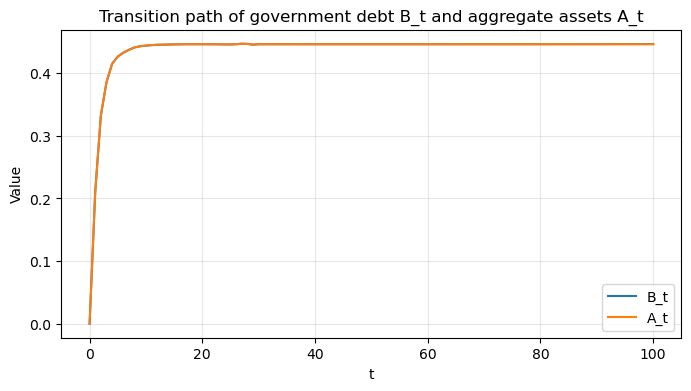

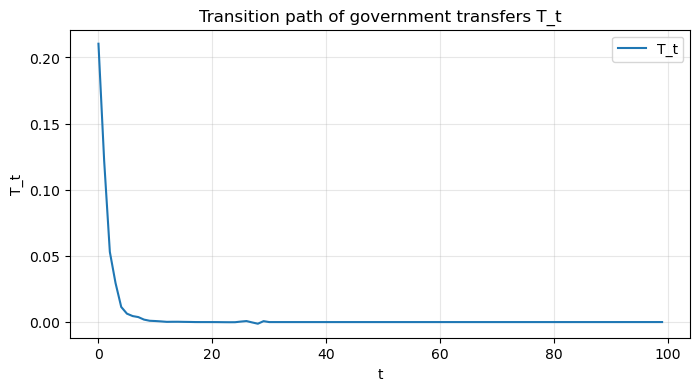

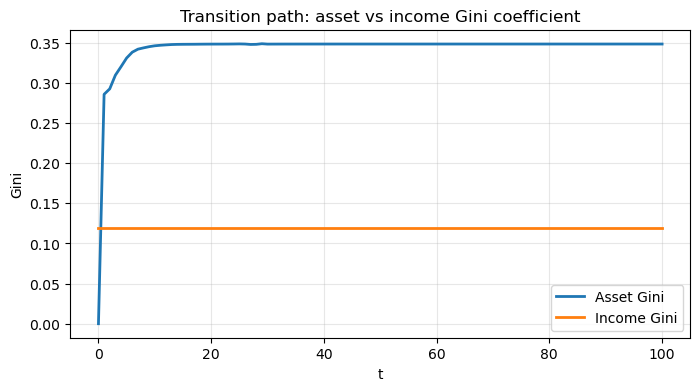

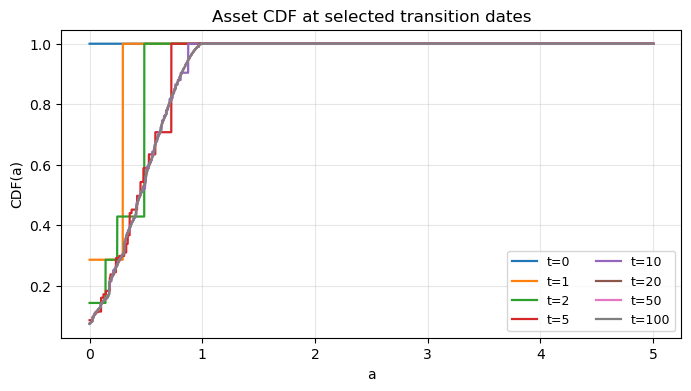

In [67]:
# Plot dynamics of B_t and A_t
plt.figure(figsize=(8, 4))
plt.plot(np.arange(res["B_path"].size), res["B_path"], label="B_t")
plt.plot(np.arange(res["A_path"].size), res["A_path"], label="A_t")
plt.xlabel("t")
plt.ylabel("Value")
plt.title("Transition path of government debt B_t and aggregate assets A_t")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot dynamics of T_t
plt.figure(figsize=(8, 4))
plt.plot(np.arange(res["T_path"].size), res["T_path"], label="T_t")
plt.xlabel("t")
plt.ylabel("T_t")
plt.title("Transition path of government transfers T_t")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot dynamics of Gini coefficients (assets + income)
t_grid = np.arange(res["lambda_path"].shape[0])
gini_assets_path = np.zeros(res["lambda_path"].shape[0])
gini_income_path = np.zeros(res["lambda_path"].shape[0])

for t in range(res["lambda_path"].shape[0]):
    # Asset marginal over (a,s)
    pdf_assets_t = np.sum(res["lambda_path"][t], axis=1)
    gini_assets_path[t] = gini_from_asset_pdf(a_grid, pdf_assets_t)
    # Income marginal over (a,s)
    pdf_income_t = np.sum(res["lambda_path"][t], axis=0)   # shape (n,)
    gini_income_path[t] = gini_from_income_pdf(y_grid, pdf_income_t)

plt.figure(figsize=(8, 4))
plt.plot(t_grid, gini_assets_path, lw=2, label="Asset Gini")
plt.plot(t_grid, gini_income_path, lw=2, label="Income Gini")
plt.xlabel("t")
plt.ylabel("Gini")
plt.title("Transition path: asset vs income Gini coefficient")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot Dynamics of CDFs for selected dates
selected_t = [0, 1, 2, 5, 10, 20, 50, res["lambda_path"].shape[0]-1]
plt.figure(figsize=(8, 4))
for tt in selected_t:
    pdf_assets_tt = np.sum(res["lambda_path"][tt], axis=1)
    cdf_assets_tt = np.cumsum(pdf_assets_tt)
    plt.plot(a_grid, cdf_assets_tt, lw=1.6, label=f"t={tt}")
plt.xlabel("a")
plt.ylabel("CDF(a)")
plt.title("Asset CDF at selected transition dates")
plt.legend(ncol=2, fontsize=9)
plt.grid(alpha=0.3)
plt.show()

max |T_t| after t_start: 0.001242166596933325
max |B_t - A_t| after t_start: 0.00028602379306919


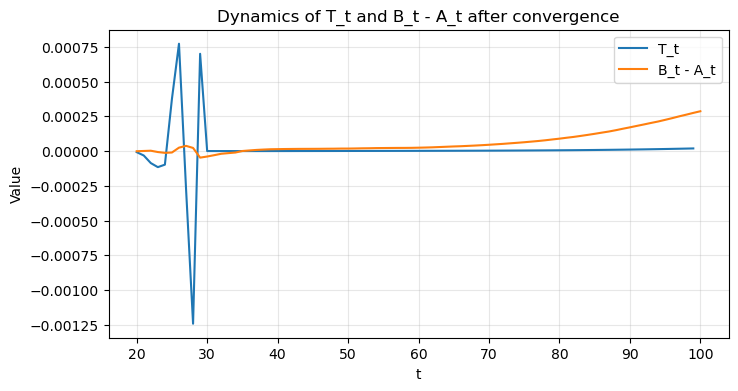

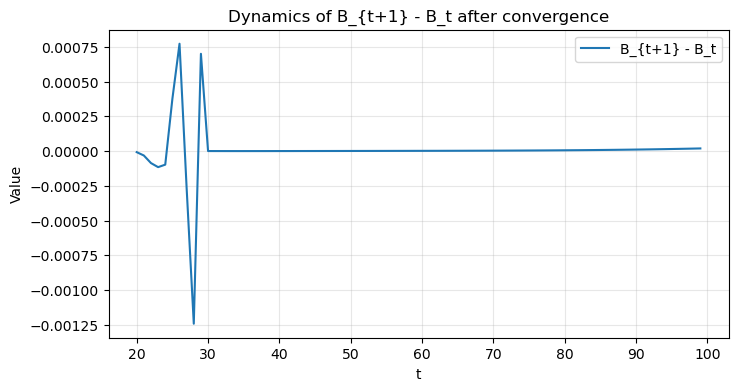

In [68]:
# print maximun T_t and B_t - A_t after convergence (Let's say t > 20 to avoid initial transition dynamics)
t_start = 20
print("max |T_t| after t_start:", np.max(np.abs(T_path[t_start:])))
print("max |B_t - A_t| after t_start:", np.max(np.abs(res["B_path"][t_start:] - res["A_path"][t_start:])))

# print dynamics of T_t and B_t - A_t after convergence (Let's say t > 20 to avoid initial transition dynamics)
plt.figure(figsize=(8, 4))
plt.plot(np.arange(t_start, res["T_path"].size), T_path[t_start:], label="T_t")
plt.plot(np.arange(t_start, res["B_path"].size), res["B_path"][t_start:] - res["A_path"][t_start:], label="B_t - A_t")
plt.xlabel("t")
plt.ylabel("Value")
plt.title("Dynamics of T_t and B_t - A_t after convergence")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# print dynamics of B_{t+1} - B_t after convergence (Let's say t > 20 to avoid initial transition dynamics)
plt.figure(figsize=(8, 4))
plt.plot(np.arange(t_start, res["B_path"].size - 1), res["B_path"][t_start + 1:] - res["B_path"][t_start:-1], label="B_{t+1} - B_t")
plt.xlabel("t")
plt.ylabel("Value")
plt.title("Dynamics of B_{t+1} - B_t after convergence")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


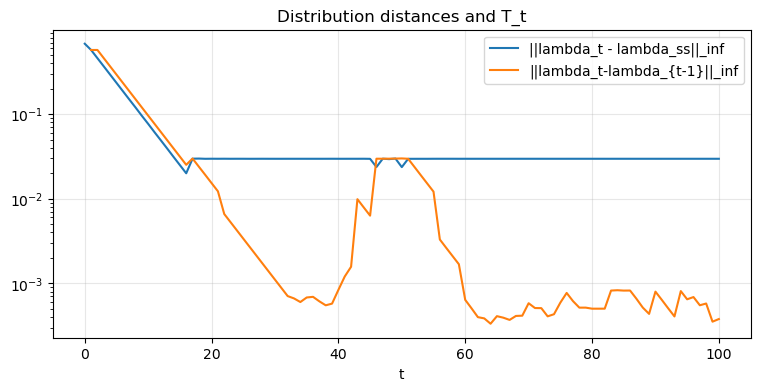

In [65]:
# 1) Distance from each period's distribution to the steady-state distribution along the path
dist_to_ss = np.array([
    np.max(np.abs(res["lambda_path"][t] - pdf_ssB))
    for t in range(res["lambda_path"].shape[0])
])

# 2) Change in distribution between adjacent periods
#    (to check whether it first converges and then is pulled away by the terminal condition)
dist_step = np.array([
    np.max(np.abs(res["lambda_path"][t+1] - res["lambda_path"][t]))
    for t in range(res["lambda_path"].shape[0] - 1)
])

# 3) plot 
plt.figure(figsize=(9,4))
plt.plot(dist_to_ss, label="||lambda_t - lambda_ss||_inf")
plt.plot(np.r_[np.nan, dist_step], label="||lambda_t-lambda_{t-1}||_inf")
plt.yscale("log")
plt.xlabel("t")
plt.title("Distribution distances and T_t")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


We can see that at $T=100$, the economy is not close to the new steady state, so we need to increase $T$ and repeat the procedure until convergence. We tried for $T=500$

In [27]:
# ---- Run at fixed T = 500 ----
res = solve_transition_with_transfers(
    T=500,
    Rprime=Rprime,
    max_iter=500,
    tol=1e-5,
    alpha=0.4,
    verbose=True
)

B_path = res["B_path"]
T_path = res["T_path"]
A_path = res["A_path"]
lambda_path = res["lambda_path"]

# check if the distribution lambda[-1] is close to the target stationary distribution pdf_ssB
final_dist = lambda_path[-1]
dist_diff = np.abs(final_dist - pdf_ssB)
print("max abs difference between final distribution and target stationary distribution:", dist_diff.max())
if dist_diff.max() < 1e-4:
    print("Final distribution is very close to target stationary distribution.")
else:
    print("Final distribution is not close to target stationary distribution.")


iter=   1, sup error=1.699e-01
iter=  10, sup error=6.579e-03
iter=  20, sup error=1.498e-03
iter=  30, sup error=6.150e-04
iter=  40, sup error=1.631e-04
iter=  50, sup error=8.026e-05
iter=  60, sup error=1.376e-04
iter=  70, sup error=1.495e-05
Converged in 72 iterations, error=9.810e-06
max abs difference between final distribution and target stationary distribution: 0.009883478391021785
Final distribution is not close to target stationary distribution.


Still not close enough, the speed of convergence is quite slow and unensured, so I give up at $T=500$.

But the aggregate variables (like $B_t$) seem to converge, below we plot the transition path of aggregate variables like $B_t$ and other interesting variables for $T=500$.

In [28]:
# print statistics describtion of lambda[-1] and pdf_ssB
def describe_distribution(dist, a_grid, y_grid):
    # Compute marginal over assets
    pdf_assets = np.sum(dist, axis=1)
    mean_a = np.sum(a_grid * pdf_assets)
    var_a = np.sum((a_grid - mean_a) ** 2 * pdf_assets)
    print(f"Mean asset: {mean_a:.4f}, Variance of asset: {var_a:.4f}")

    # Compute marginal over y states
    pdf_y = np.sum(dist, axis=0)
    mean_y = np.sum(y_grid * pdf_y)
    var_y = np.sum((y_grid - mean_y) ** 2 * pdf_y)
    print(f"Mean y: {mean_y:.4f}, Variance of y: {var_y:.4f}")

describe_distribution(final_dist, a_grid, y_grid)
describe_distribution(pdf_ssB, a_grid, y_grid) 

Mean asset: 0.4464, Variance of asset: 0.0728
Mean y: 0.8571, Variance of y: 0.0510
Mean asset: 0.4464, Variance of asset: 0.0728
Mean y: 0.8571, Variance of y: 0.0510


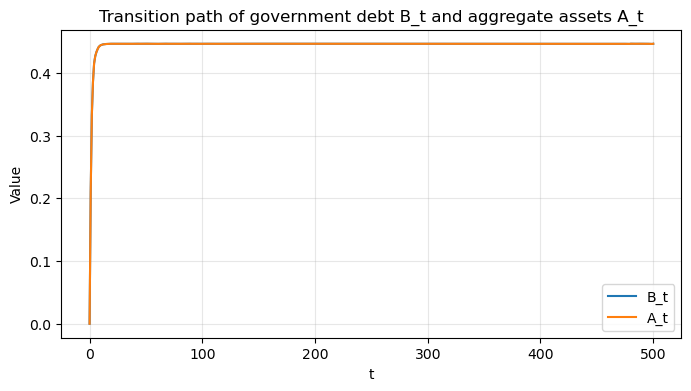

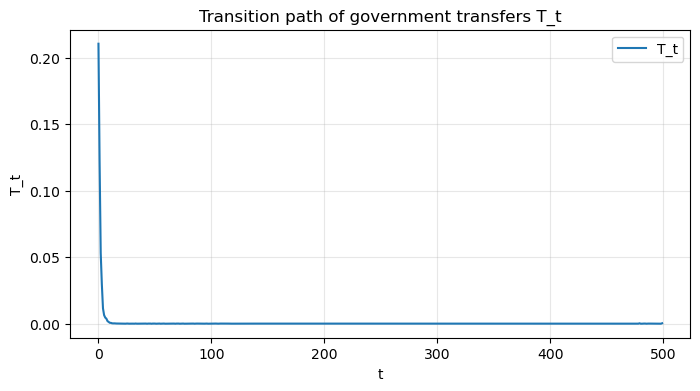

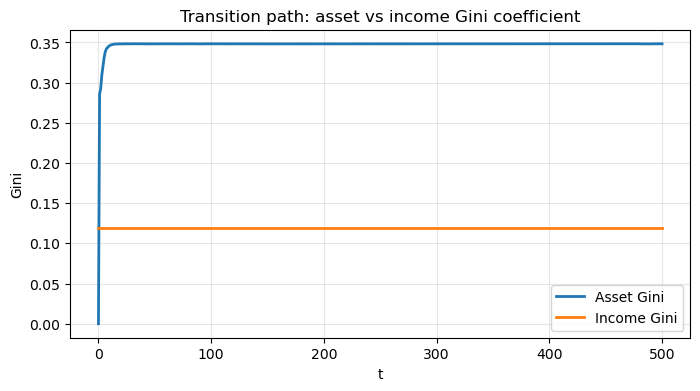

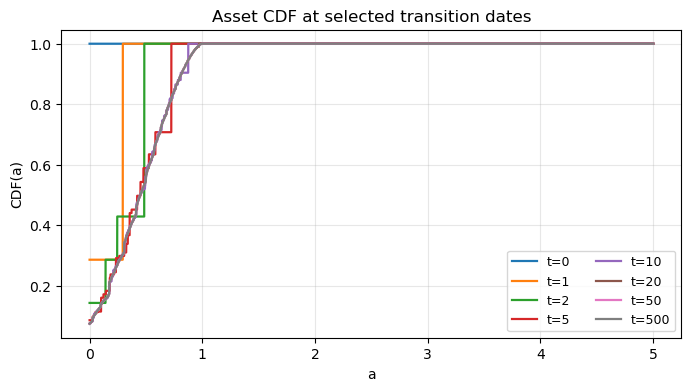

In [29]:
# Plot dynamics of B_t and A_t
plt.figure(figsize=(8, 4))
plt.plot(np.arange(res["B_path"].size), res["B_path"], label="B_t")
plt.plot(np.arange(res["A_path"].size), res["A_path"], label="A_t")
plt.xlabel("t")
plt.ylabel("Value")
plt.title("Transition path of government debt B_t and aggregate assets A_t")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot dynamics of T_t
plt.figure(figsize=(8, 4))
plt.plot(np.arange(res["T_path"].size), res["T_path"], label="T_t")
plt.xlabel("t")
plt.ylabel("T_t")
plt.title("Transition path of government transfers T_t")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot dynamics of Gini coefficients (assets + income)
t_grid = np.arange(res["lambda_path"].shape[0])
gini_assets_path = np.zeros(res["lambda_path"].shape[0])
gini_income_path = np.zeros(res["lambda_path"].shape[0])

for t in range(res["lambda_path"].shape[0]):
    # Asset marginal over (a,s)
    pdf_assets_t = np.sum(res["lambda_path"][t], axis=1)
    gini_assets_path[t] = gini_from_asset_pdf(a_grid, pdf_assets_t)
    # Income marginal over (a,s)
    pdf_income_t = np.sum(res["lambda_path"][t], axis=0)   # shape (n,)
    gini_income_path[t] = gini_from_income_pdf(y_grid, pdf_income_t)

plt.figure(figsize=(8, 4))
plt.plot(t_grid, gini_assets_path, lw=2, label="Asset Gini")
plt.plot(t_grid, gini_income_path, lw=2, label="Income Gini")
plt.xlabel("t")
plt.ylabel("Gini")
plt.title("Transition path: asset vs income Gini coefficient")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot Dynamics of CDFs for selected dates
selected_t = [0, 1, 2, 5, 10, 20, 50, res["lambda_path"].shape[0]-1]
plt.figure(figsize=(8, 4))
for tt in selected_t:
    pdf_assets_tt = np.sum(res["lambda_path"][tt], axis=1)
    cdf_assets_tt = np.cumsum(pdf_assets_tt)
    plt.plot(a_grid, cdf_assets_tt, lw=1.6, label=f"t={tt}")
plt.xlabel("a")
plt.ylabel("CDF(a)")
plt.title("Asset CDF at selected transition dates")
plt.legend(ncol=2, fontsize=9)
plt.grid(alpha=0.3)
plt.show()

max |T_t| after t_start: 0.00027724354790914507
max |B_t - A_t| after t_start: 1.8620756990384013e-05


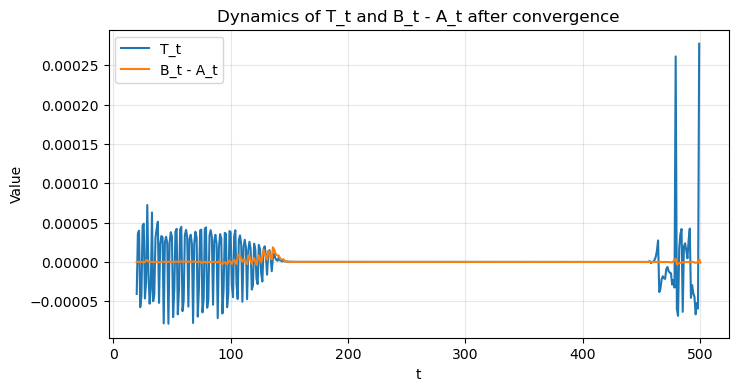

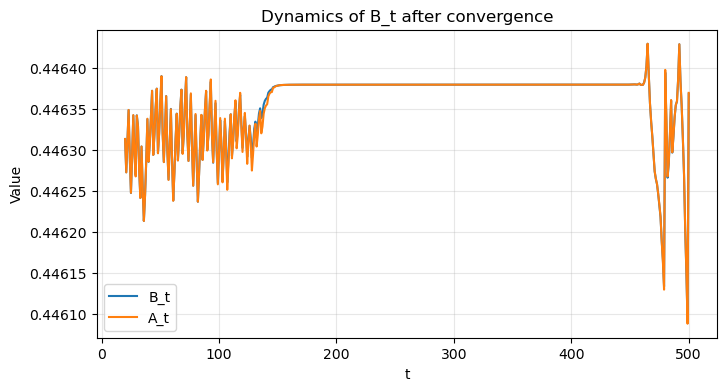

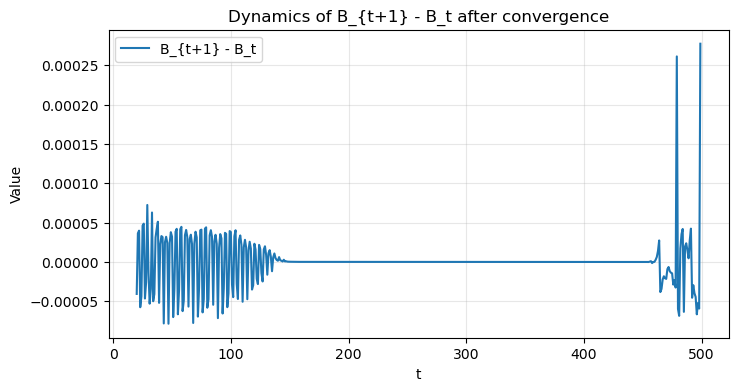

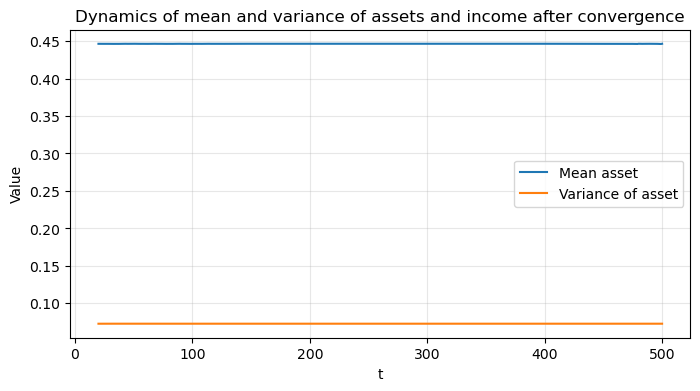

In [30]:
# print maximun T_t and B_t - A_t after convergence (Let's say t > 20 to avoid initial transition dynamics)
t_start = 20
print("max |T_t| after t_start:", np.max(np.abs(T_path[t_start:])))
print("max |B_t - A_t| after t_start:", np.max(np.abs(res["B_path"][t_start:] - res["A_path"][t_start:])))

# print dynamics of T_t and B_t - A_t after convergence (Let's say t > 20 to avoid initial transition dynamics)
plt.figure(figsize=(8, 4))
plt.plot(np.arange(t_start, res["T_path"].size), T_path[t_start:], label="T_t")
plt.plot(np.arange(t_start, res["B_path"].size), res["B_path"][t_start:] - res["A_path"][t_start:], label="B_t - A_t")
plt.xlabel("t")
plt.ylabel("Value")
plt.title("Dynamics of T_t and B_t - A_t after convergence")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# print dynamics of B_t and A_t after convergence (Let's say t > 20 to avoid initial transition dynamics)
plt.figure(figsize=(8, 4))
plt.plot(np.arange(t_start, res["B_path"].size), res["B_path"][t_start:], label="B_t")
plt.plot(np.arange(t_start, res["A_path"].size), res["A_path"][t_start:], label="A_t")
plt.xlabel("t")
plt.ylabel("Value")
plt.title("Dynamics of B_t after convergence")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# print dynamics of B_{t+1} - B_t after convergence (Let's say t > 20 to avoid initial transition dynamics)
plt.figure(figsize=(8, 4))
plt.plot(np.arange(t_start, res["B_path"].size - 1), res["B_path"][t_start + 1:] - res["B_path"][t_start:-1], label="B_{t+1} - B_t")
plt.xlabel("t")
plt.ylabel("Value")
plt.title("Dynamics of B_{t+1} - B_t after convergence")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# print dynamics of statistics describtion lambda[t] after convergence (Let's say t > 20 to avoid initial transition dynamics)
# we can use the same function describe_distribution to print mean and variance of assets and income for lambda[t] at each t, then we plot the dynamics of mean and variance of assets after convergence (Let's say t > 20 to avoid initial transition dynamics)
mean_a_path = np.zeros(res["lambda_path"].shape[0])
var_a_path = np.zeros(res["lambda_path"].shape[0])
mean_y_path = np.zeros(res["lambda_path"].shape[0])
var_y_path = np.zeros(res["lambda_path"].shape[0])
for t in range(res["lambda_path"].shape[0]):
    dist = res["lambda_path"][t]
    # Compute marginal over assets
    pdf_assets = np.sum(dist, axis=1)
    mean_a_path[t] = np.sum(a_grid * pdf_assets)
    var_a_path[t] = np.sum((a_grid - mean_a_path[t]) ** 2 * pdf_assets)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(t_start, res["lambda_path"].shape[0]), mean_a_path[t_start:], label="Mean asset")
plt.plot(np.arange(t_start, res["lambda_path"].shape[0]), var_a_path[t_start:], label="Variance of asset")
plt.xlabel("t")
plt.ylabel("Value")
plt.title("Dynamics of mean and variance of assets and income after convergence")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


I want to check whether the distribution actually gets close to the new steady-state distribution in the middle of the transition, but then moves away again because $T_t$ starts oscillating near the terminal periods.

To evaluate this, I compute along the transition:
$$
\sup_{a,s} | \lambda_T(a,s) - \lambda^{ss}(a,s) |
$$
and examine how this distance evolves over time.


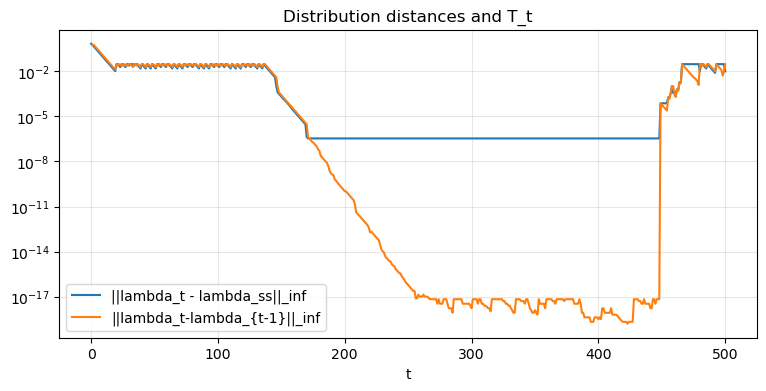

In [31]:
# 1) Distance from each period's distribution to the steady-state distribution along the path
dist_to_ss = np.array([
    np.max(np.abs(res["lambda_path"][t] - pdf_ssB))
    for t in range(res["lambda_path"].shape[0])
])

# 2) Change in distribution between adjacent periods
#    (to check whether it first converges and then is pulled away by the terminal condition)
dist_step = np.array([
    np.max(np.abs(res["lambda_path"][t+1] - res["lambda_path"][t]))
    for t in range(res["lambda_path"].shape[0] - 1)
])

# 3) plot 
plt.figure(figsize=(9,4))
plt.plot(dist_to_ss, label="||lambda_t - lambda_ss||_inf")
plt.plot(np.r_[np.nan, dist_step], label="||lambda_t-lambda_{t-1}||_inf")
plt.yscale("log")
plt.xlabel("t")
plt.title("Distribution distances and T_t")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


The aggregate variables seems to converge after $\bar t$, specifically, $T_t$ converges to zero after $\bar t$

Thus, with the converged $T_t = 0$ and constant $R_t = R'$, for any $\tau \geq \bar t$ the household problem can be approximately written as:
$$
V_\tau(a,s) = \max_{a'}\left\{u(c)+\beta\sum_{s'}p_{ss'}V_{\tau+1}(a',s')\right\}, \quad \text{s.t.} \\
c = y(s)+R'a - a' \\
a' \geq 0
$$

From $T$ backward to $\bar t$, we can prove that $V_\tau = V^*$ and $g_\tau = g^*$ for all $\tau \geq \bar t$, where $V^*$ and $g^*$ are the value function and policy function solved under $(R',T)=(1,0)$ in part (c).

Therefore, we can use the same policy function $g^*$ to calculate the transition matrix for all $t \ge \bar t$ in the transition, which substantially reduces the computational burden of solving the transition path for large $T$.

### Faster Calculation Algorithm for Transition Path

To reduce computation for large horizons, we use the fact that after some date $\bar t$, aggregate variables are already close to steady state, in particular
$$
|T_t|<\varepsilon_T \quad (\text{with } R_t\equiv R'=1).
$$
Then the household problem is approximately the steady-state problem under $(R',T)=(1,0)$, so I can use the steady-state policy $g^*$ to compute the transition matrix for all $t \ge \bar t$ without solving the Bellman equation at each date, which substantially reduces the computational burden of solving the transition path for large $T$.


The key point is to find a cutoff date $\bar t$ such that for all $t \ge \bar t$, the transition path is close enough to the new steady state.

For early dates $t<\bar t$, we still have the full fixed point iteration:
$$
T_t = B_{t+1}-B_t,\qquad B_t=A_t,\qquad g_t \text{ depends on future } \{T_j\}.
$$
So we keep fixed-point iteration only on the short segment $t=0,\dots,\bar t$.

For the tail $t\ge \bar t$, we impose that
$$
V_{\bar t}=V^*,\qquad g_t=g^*,
$$
where $(V^*,g^*)$ are solved once from the steady-state problem with $(R',T)=(1,0)$.

#### What we do

First we try a large $T=1000$ and compute the transition path with the full fixed point iteration. 

Then we check when aggregate variables get close enough to the new steady state, and set that date as $\bar t$. 

Then we can use the policy function solved from the steady-state problem to compute the transition matrix for all $t \ge \bar t$ without solving the Bellman equation at each date.



In [32]:
# We already haveres (from T=1000 run), policyB, pdf_ssB, p, a_grid, n, grid_points

T_path = res["T_path"]            # length 1000
lambda_path = res["lambda_path"]  # shape (1001, grid_points, n)

# 1) Find first tbar where T_t is small for a whole tail window
eps_T = 1e-6
tail_window = 100  # require next 50 periods all small

cands = []
for t in range(len(T_path) - tail_window + 1):
    if np.max(np.abs(T_path[t:t+tail_window])) < eps_T:
        cands.append(t)

if len(cands) == 0:
    print("No tbar found under current eps_T; try larger eps_T (e.g. 1e-5).")
    tbar = None
else:
    tbar = int(cands[0])
    print("tbar =", tbar)
    print("max |T_t| on [tbar, tbar+window):", np.max(np.abs(T_path[tbar:tbar+tail_window])))





tbar = 146
max |T_t| on [tbar, tbar+window): 7.809631065169853e-07


In [33]:
# 2) From tbar onward, freeze policy at steady-state policy g* = policyB
#    and iterate distribution forward only

lam = lambda_path[tbar].copy()
eps_lambda = 1e-10
max_extra = 2000

# store diagnostics
dist_step = []
dist_to_ss = []
A_tail = []

# A at tbar
A0 = np.sum(a_grid * np.sum(lam, axis=1))
A_tail.append(A0)

for k in range(max_extra):
    nxt = np.zeros_like(lam)

    for i in range(grid_points):
        for s in range(n):
            mass = lam[i, s]
            if mass > 0.0:
                ip = policyB[i, s]   # frozen policy g*
                for sp in range(n):
                    nxt[ip, sp] += p[s, sp] * mass

    d_step = np.max(np.abs(nxt - lam))
    d_ss = np.max(np.abs(nxt - pdf_ssB))

    dist_step.append(d_step)
    dist_to_ss.append(d_ss)

    A_next = np.sum(a_grid * np.sum(nxt, axis=1))
    A_tail.append(A_next)

    lam = nxt
    if d_step < eps_lambda:
        print(f"Tail distribution converged after {k+1} extra steps.")
        break

print("final max distance to steady-state distribution:", dist_to_ss[-1])


Tail distribution converged after 56 extra steps.
final max distance to steady-state distribution: 3.405175455246535e-07


In [34]:
# 3) Optional: build tail B,T paths using market clearing B=A in the frozen tail
A_tail = np.array(A_tail)  # starts at tbar
B_tail = A_tail.copy()
T_tail = B_tail[1:] - B_tail[:-1]  # since R'=1

print("tail max |T_t| under frozen policy:", np.max(np.abs(T_tail)))


tail max |T_t| under frozen policy: 9.738144837179163e-07


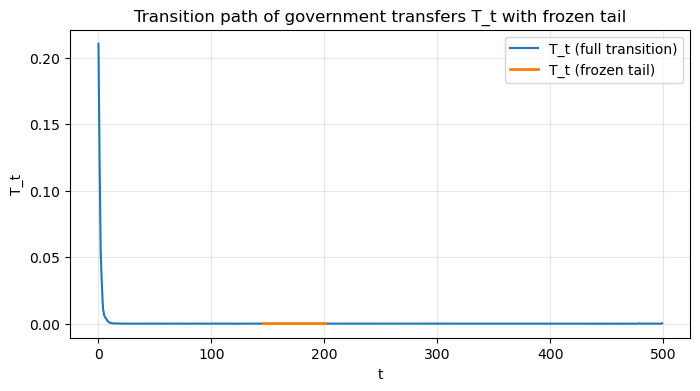

In [35]:
# Plot dynamics of T_t and B_t in the whole transition, highlighting the tail
plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(T_path)), T_path, label="T_t (full transition)")
plt.plot(np.arange(tbar, tbar + len(T_tail)), T_tail, label="T_t (frozen tail)", lw=2)
plt.xlabel("t")
plt.ylabel("T_t")
plt.title("Transition path of government transfers T_t with frozen tail")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Part (q)

Using the value function from part (c) to evaluate welfare in part (p)/(o) would be incorrect.

The value function in part (c), $V^{B}$, is the value under the **new stationary environment** with constant policy variables. It assumes households are already in that steady-state continuation problem.

In the case with transfers chosen to satisfy the government budget constraint with equality, the transition features a **time-varying** sequence $\{T_t\}$ (and potentially $\{R_t\}$). Therefore, welfare at $t=0$ must be computed from the transition value function:
$$
V_0(a,s)=\max_{\{a_{t+1}\}}\sum_{t=0}^{\infty}\beta^t u(c_t)
\quad \text{s.t.}\quad
c_t+a_{t+1}\le R_t a_t + y_t + T_t.
$$

If we instead use $V^{B}$ from part (c), we ignore the welfare effects of the transition path itself (including transitional gains/losses from the sequence of transfers). So the welfare comparison would be biased and generally invalid for this case.
